In [29]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
import json
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
from geopandas.tools import sjoin
from pyproj import Proj

In [30]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [31]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [32]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
0.8443906332745678 0.4051139537590416


In [33]:
shp.crs

{}

In [34]:
ward_frame = gpd.read_file('../Data/Geo_Data/geo/london_wards.shp')
wardCodeDict = {}
for index , row in ward_frame.iterrows():
    wardCodeDict[row['NAME']] = row['CODE']

In [35]:
wardCodeDict

{'Chessington South Ward': 'E05000405',
 'Tolworth and Hook Rise Ward': 'E05000414',
 'Berrylands Ward': 'E05000401',
 'Alexandra Ward': 'E05000266',
 'Beverley Ward': 'E05000402',
 'Coombe Hill Ward': 'E05000406',
 'Chessington North and Hook Ward': 'E05000404',
 'Surbiton Hill Ward': 'E05000413',
 'Old Malden Ward': 'E05000410',
 "St. Mark's Ward": 'E05000412',
 'Grove Ward': 'E05000408',
 'Canbury Ward': 'E05000403',
 'Norbiton Ward': 'E05000409',
 'Coombe Vale Ward': 'E05000407',
 'St. James Ward': 'E05000411',
 'Tudor Ward': 'E05000415',
 'Coulsdon East Ward': 'E05000150',
 'Selsdon and Ballards Ward': 'E05000162',
 'Coulsdon West Ward': 'E05000151',
 'Waddon Ward': 'E05000167',
 'Kenley Ward': 'E05000156',
 'Purley Ward': 'E05000159',
 'Sanderstead Ward': 'E05000160',
 'Heathfield Ward': 'E05000523',
 'Fairfield Ward': 'E05000614',
 'Broad Green Ward': 'E05000149',
 'West Thornton Ward': 'E05000168',
 'Bensham Manor Ward': 'E05000148',
 'Norbury Ward': 'E05000158',
 'New Addingto

/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7fa64cfc44e0>)

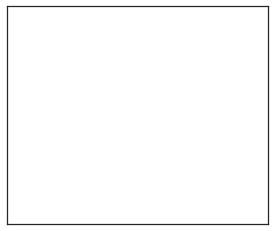

In [36]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    '../Data/Geo_Data/geo/london_wards',
    'london',
    color='none',
    zorder=2)

In [37]:
m(58.6, -0)

(8381524.148273519, -5684368.573044857)

In [38]:
london_polys = []
borough_names = []
for w_ind in range(len(m.london_info)):
    w = m.london_info[w_ind]
    if w['CODE'] in borough_names:
        london_polys[-1] = Polygon(m.london[w_ind])
        continue
    borough_names.append(w['CODE'])    
    london_polys.append(Polygon(m.london[w_ind]))
    
df_map = pd.DataFrame({
    'poly': london_polys,
    'borough_name': borough_names,
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['borough_name'] = df_map['borough_name'].str.strip()

In [43]:
data_file1 = '../Data/Geo_Data/GreaterLondon_NoRot_segnet.csv'
lonlat_data_file = '../Data/Geo_Data/greater_london_points.csv'
stephen_data = 'scratchpad/GLa_tree_loc.csv'

In [44]:
pd.read_csv(data_file1,sep='|').head()

,WayID,PointID,Rotation,SegnetRatios
0,8363123,1077704848,0,"[0.27945023148148146, 0.09033564814814815, 0.0..."
1,16790097,173736413,0,"[0.2711574074074074, 0.24954282407407408, 0.00..."
2,7995502,1564517311,0,"[0.36464699074074075, 0.06125, 0.0211747685185..."
3,8375945,195712,0,"[0.2757118055555556, 0.14144675925925926, 0.00..."
4,2955913,629000,0,"[0.08201967592592592, 0.5701157407407408, 0.00..."


In [45]:
Stephen_data = pd.read_csv(stephen_data)
Stephen_data .head()

,GLA_ID,Tree,treePercen,lon,lat
0,37439,1437,0.008316,-0.160338,51.590471
1,71396,27531,0.159323,0.093273,51.351336
2,76511,24614,0.142442,0.039291,51.461303
3,53705,9961,0.057645,-0.021153,51.432981
4,71914,27405,0.158594,0.101934,51.399035


In [46]:

trees_dict = {'id':[], 'geometry':[] , 'treePercent':[]}
for index,row in Stephen_data.iterrows():
    trees_dict['id'].append(row['GLA_ID'])
    trees_dict['geometry'].append(Point(row['lon'],row['lat']))
    trees_dict['treePercent'].append(row['treePercen'])

In [47]:
Stephen_trees = pd.DataFrame.from_dict(trees_dict)

In [48]:
stephen_trees_gdf = gpd.GeoDataFrame(Stephen_trees, geometry='geometry', crs={'init':'EPSG:4326'})

In [49]:
stephen_trees_gdf.head()

,id,geometry,treePercent
0,37439.0,POINT (-0.16034 51.59047),0.008316
1,71396.0,POINT (0.09327 51.35134),0.159323
2,76511.0,POINT (0.03929 51.46130),0.142442
3,53705.0,POINT (-0.02115 51.43298),0.057645
4,71914.0,POINT (0.10193 51.39903),0.158594


In [50]:
stephen_trees_WGS84 = stephen_trees_gdf.to_crs({'proj': 'tmerc','ellps' : 'WGS84'})

In [51]:
stephen_trees_gdf.head()

,id,geometry,treePercent
0,37439.0,POINT (-0.16034 51.59047),0.008316
1,71396.0,POINT (0.09327 51.35134),0.159323
2,76511.0,POINT (0.03929 51.46130),0.142442
3,53705.0,POINT (-0.02115 51.43298),0.057645
4,71914.0,POINT (0.10193 51.39903),0.158594


In [52]:
stephen_trees_WGS84.head()

,id,geometry,treePercent
0,37439.0,POINT (-11111.867 5717790.119),0.008316
1,71396.0,POINT (6497.965 5691176.612),0.159323
2,76511.0,POINT (2730.687 5703407.654),0.142442
3,53705.0,POINT (-1471.037 5700256.170),0.057645
4,71914.0,POINT (7093.967 5696484.080),0.158594


In [53]:
fdata_map_points = {}


for index, row in Stephen_data.iterrows():
    scene_list = [row['treePercen']]
    latitude  = row['lat']
    longitude = row['lon']
    fdata_map_points[m(longitude, latitude)] = scene_list

In [54]:
fdata_map_points

{(24144.939447465265, 35013.39745457863): [0.008315972],
 (42479.163198859664, 8884.716352782474): [0.15932291699999998],
 (38378.5364145888, 21011.490916408686): [0.14244213],
 (34263.42665516751, 17745.696871608117): [0.057644676],
 (42930.31383288189, 14207.854632994713): [0.15859375],
 (22204.712317725658, 21047.527936392027): [0.011990741000000001],
 (37042.03510687503, 11328.156634097482): [0.17117476899999998],
 (41363.20289404155, 29704.878040033014): [0.005237269],
 (28698.265682529833, 38395.7712275917): [0.106527778],
 (37849.83811945858, 29631.339056926925): [0.0044097220000000005],
 (36829.93121245279, 16510.16943928387): [0.023130787000000003],
 (26765.96689125002, 23198.32452027392): [0.056099537000000005],
 (41504.2293283327, 22385.48927509642): [0.141197917],
 (12183.774021349498, 34718.31037347441): [0.008668981],
 (24403.575709359313, 34951.45786527466): [0.21255787],
 (15108.448662302253, 33527.334768932225): [0.073877315],
 (21246.822183526587, 22661.604403610312):

In [61]:
# fdata_map_points.keys()

In [63]:
map_points = pd.Series([Point(map_point) for map_point in fdata_map_points])
plaque_points = MultiPoint(list(map_points.values))
print(len(plaque_points))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = list(filter(wards_polygon.contains, plaque_points))

104777


In [64]:
ldn_points

 ...]

In [65]:
map_points = pd.Series(
    [Point(mapped_x, mapped_y) for (mapped_x, mapped_y) in fdata_map_points])
gsview_points = MultiPoint(list(map_points.values))
# calculate points that fall within the London boundary
gsview_ldn_points = list(filter(wards_polygon.contains, gsview_points))
# create a MultiPoint which we can check for set membership
df_map['gsview_point_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, gsview_ldn_points)))
df_map['gsview_segnet_tags_dict'] = df_map['gsview_point_list'].map(lambda x: [fdata_map_points[(p.x,p.y)] for p in x])

In [68]:
df_map

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal
0,"POLYGON ((13004.06946655408 5643.556705337571,...",E05000405,7.557384e+06,75.573841,"[POINT (14395.16284888203 9480.470449201151), ...","[[0.056689815], [0.041608796], [0.084826389], ...",[0.08016600295804195],[11.463738422999999],0.080166,11.463738
1,"POLYGON ((14432.57909437221 10890.80719853038,...",E05000414,2.596590e+06,25.965904,"[POINT (16259.86737917352 11068.04687376085), ...","[[0.081915509], [0.04477430599999999], [0.0426...",[0.0563497430513089],[10.7628009228],0.056350,10.762801
2,"POLYGON ((14710.57509324689 12747.79659924857,...",E05000401,1.454965e+06,14.549655,"[POINT (15494.08747970358 12413.59817692518), ...","[[0.15564814800000001], [0.033940972], [0.1183...",[0.10434428858415844],[10.538773147000002],0.104344,10.538773
3,"POLYGON ((17083.95639092114 12354.05967221505,...",E05000400,2.687010e+06,26.870103,"[POINT (16733.06237564847 12604.16230425649), ...","[[0.062546296], [0.050758102], [0.016105324], ...",[0.0849857403986928],[13.002818281],0.084986,13.002818
4,"POLYGON ((18675.541683762 13589.62372095857, 1...",E05000402,1.879597e+06,18.795975,"[POINT (17204.2266147552 13491.4796509991), PO...","[[0.16829861100000001], [0.073796296], [0.0331...",[0.06420874999199999],[8.026093749],0.064209,8.026094
...,...,...,...,...,...,...,...,...,...,...
644,"POLYGON ((29924.26240807216 26438.32918597994,...",E05009289,1.123901e+05,1.123901,"[POINT (30102.79210341835 26569.14405422713), ...","[[0.015115741], [0.013541667], [0.121388889], ...",[0.019608961728571427],[0.6863136605],0.019609,0.686314
645,"POLYGON ((29614.24511027665 27061.95915219319,...",E05009295,8.162131e+04,0.816213,"[POINT (29540.562080334 26944.30551812067), PO...","[[0.0016666670000000001], [0.003854167], [0.00...",[0.013895502785714284],[0.19453703899999997],0.013896,0.194537
646,"POLYGON ((29488.99825973884 27173.1999053428, ...",E05009299,1.507132e+05,1.507132,"[POINT (29168.4164149338 27125.83192274868), P...","[[0.000873843], [0.07961805599999999], [0.0254...",[0.022412808681333336],[0.6723842604400001],0.022413,0.672384
647,"POLYGON ((30423.14740751 26418.42371497213, 30...",E05009308,6.292893e+04,0.629289,"[POINT (30368.90121992026 26599.13579971032), ...","[[0.02349537], [0.003761574], [0.028599537], [...",[0.015314078181818182],[0.16845486],0.015314,0.168455


In [67]:
np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[0]), axis=0)
scene_tags = []
total_pixels = []
for index in range(len(df_map)):
    scene_tags.append(np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
    total_pixels.append(np.sum(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
df_map['gsview_tags'] = scene_tags
df_map['total_gsview_pixels'] = total_pixels

# cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']
cats = ['Tree']

scene_tags_transpose = list(zip(*scene_tags))
scene_total_transpose = list(zip(*total_pixels))

for index in range(len(cats)):
    cat = cats[index]
    cat_total =  cats[index] + 'Total'
    df_map[cat] = scene_tags_transpose[index]
    df_map[cat_total] = scene_total_transpose[index]
    

In [69]:
np.array(df_map['gsview_segnet_tags_dict'].iloc[index])

array([[0.05668981],
       [0.0416088 ],
       [0.08482639],
       [0.0333044 ],
       [0.12553819],
       [0.09473958],
       [0.04586806],
       [0.00264468],
       [0.01460648],
       [0.03239583],
       [0.18480903],
       [0.01968171],
       [0.03433449],
       [0.07637732],
       [0.01539352],
       [0.16035301],
       [0.08165509],
       [0.09386574],
       [0.01223958],
       [0.14140625],
       [0.09905093],
       [0.07766782],
       [0.0379456 ],
       [0.01626736],
       [0.15552662],
       [0.00293982],
       [0.03681134],
       [0.05212384],
       [0.05287037],
       [0.02756366],
       [0.08910301],
       [0.16082755],
       [0.04175347],
       [0.0425    ],
       [0.07501157],
       [0.07645255],
       [0.01850116],
       [0.00599537],
       [0.17724537],
       [0.06833912],
       [0.09631366],
       [0.00766782],
       [0.14814815],
       [0.11355324],
       [0.14369213],
       [0.04235532],
       [0.01213542],
       [0.111

In [71]:
df_map['samples'] = df_map['gsview_point_list'].apply(lambda x: len(x))

In [72]:
df_map

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal,samples
0,"POLYGON ((13004.06946655408 5643.556705337571,...",E05000405,7.557384e+06,75.573841,"[POINT (14395.16284888203 9480.470449201151), ...","[[0.056689815], [0.041608796], [0.084826389], ...",[0.08016600295804195],[11.463738422999999],0.080166,11.463738,143
1,"POLYGON ((14432.57909437221 10890.80719853038,...",E05000414,2.596590e+06,25.965904,"[POINT (16259.86737917352 11068.04687376085), ...","[[0.081915509], [0.04477430599999999], [0.0426...",[0.0563497430513089],[10.7628009228],0.056350,10.762801,191
2,"POLYGON ((14710.57509324689 12747.79659924857,...",E05000401,1.454965e+06,14.549655,"[POINT (15494.08747970358 12413.59817692518), ...","[[0.15564814800000001], [0.033940972], [0.1183...",[0.10434428858415844],[10.538773147000002],0.104344,10.538773,101
3,"POLYGON ((17083.95639092114 12354.05967221505,...",E05000400,2.687010e+06,26.870103,"[POINT (16733.06237564847 12604.16230425649), ...","[[0.062546296], [0.050758102], [0.016105324], ...",[0.0849857403986928],[13.002818281],0.084986,13.002818,153
4,"POLYGON ((18675.541683762 13589.62372095857, 1...",E05000402,1.879597e+06,18.795975,"[POINT (17204.2266147552 13491.4796509991), PO...","[[0.16829861100000001], [0.073796296], [0.0331...",[0.06420874999199999],[8.026093749],0.064209,8.026094,125
...,...,...,...,...,...,...,...,...,...,...,...
644,"POLYGON ((29924.26240807216 26438.32918597994,...",E05009289,1.123901e+05,1.123901,"[POINT (30102.79210341835 26569.14405422713), ...","[[0.015115741], [0.013541667], [0.121388889], ...",[0.019608961728571427],[0.6863136605],0.019609,0.686314,35
645,"POLYGON ((29614.24511027665 27061.95915219319,...",E05009295,8.162131e+04,0.816213,"[POINT (29540.562080334 26944.30551812067), PO...","[[0.0016666670000000001], [0.003854167], [0.00...",[0.013895502785714284],[0.19453703899999997],0.013896,0.194537,14
646,"POLYGON ((29488.99825973884 27173.1999053428, ...",E05009299,1.507132e+05,1.507132,"[POINT (29168.4164149338 27125.83192274868), P...","[[0.000873843], [0.07961805599999999], [0.0254...",[0.022412808681333336],[0.6723842604400001],0.022413,0.672384,30
647,"POLYGON ((30423.14740751 26418.42371497213, 30...",E05009308,6.292893e+04,0.629289,"[POINT (30368.90121992026 26599.13579971032), ...","[[0.02349537], [0.003761574], [0.028599537], [...",[0.015314078181818182],[0.16845486],0.015314,0.168455,11


In [73]:
df_map['TreeScore_norm'] = (df_map['TreeTotal']/df_map['samples'])

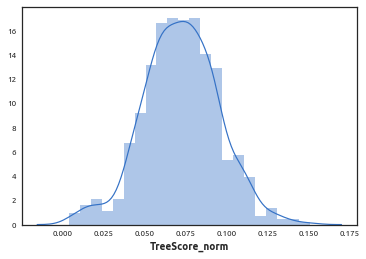

In [74]:
sns.distplot(df_map['TreeScore_norm'])

In [75]:
Tree_df = df_map[['borough_name','TreeScore_norm','samples']]

In [76]:
Tree_df.to_csv('Revised_tree_score.csv')

In [77]:
df_map.to_csv('London_ward_tree_scores_stephen.csv')

In [78]:
df_map.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree',
       'TreeTotal', 'samples', 'TreeScore_norm'],
      dtype='object')

In [80]:
tree_data = pd.read_csv('../Data/Geo_Data/london_street_trees_gla_20180214.csv',engine='python')

In [198]:
accesible_trees = gpd.read_file('scratchpad/accessible_trees.shp')

inaccessible_trees = gpd.read_file('scratchpad/inaccessible_trees.shp')

In [200]:
accesible_trees.head()

,gla_id,borough,species_na,common_nam,display_na,load_date,easting,northing,longitude,latitude,...,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,glaid_1031,Barking,Tilia cordata,None,Lime,20180214,545308.0,183363.0,0.093434,51.530502,...,None,Alfred's Gardens,False,33742448,None,None,385978878,None,None,POINT (0.09343 51.53050)
1,glaid_1032,Barking,Malus tschonoskii,None,Apple,20180214,545314.0,183366.0,0.093517,51.530521,...,None,Alfred's Gardens,False,33742448,None,None,385978878,None,None,POINT (0.09352 51.53052)
2,glaid_1033,Barking,Liquidambar styraciflua,None,Other,20180214,545335.0,183372.0,0.093831,51.530571,...,None,Alfred's Gardens,False,33742448,None,None,385978878,None,None,POINT (0.09383 51.53057)
3,glaid_1034,Barking,Tilia cordata,None,Lime,20180214,545352.0,183377.0,0.094073,51.530617,...,None,Alfred's Gardens,False,33742448,None,None,385978878,None,None,POINT (0.09407 51.53062)
4,glaid_1035,Barking,Tilia cordata,None,Lime,20180214,545370.0,183383.0,0.094331,51.530663,...,None,Alfred's Gardens,False,33742448,None,None,385978878,None,None,POINT (0.09433 51.53066)


In [82]:
tree_data.head()

,gla_id,borough,species_name,common_name,display_name,load_date,easting,northing,longitude,latitude
0,glaid_0,Barking,Acer pseudoplatanus 'brilliantissimum',NaN,Maple,20180214,548320.0,189593.0,0.139454,51.585695
1,glaid_1,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548297.0,189590.0,0.139123,51.585670
2,glaid_2,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548289.0,189592.0,0.139004,51.585689
3,glaid_3,Barking,Taxus baccata fastigiata,NaN,Other,20180214,548298.0,189597.0,0.139134,51.585732
4,glaid_4,Barking,Robinia pseudoacacia,NaN,Black Locust,20180214,548308.0,189607.0,0.139288,51.585819


In [201]:
AccessTreeData = pd.DataFrame.merge(accesible_trees,tree_data,left_on='gla_id',right_on='gla_id',how='inner')

In [203]:
InaccessTreeData = pd.DataFrame.merge(inaccessible_trees,tree_data,left_on='gla_id',right_on='gla_id',how='inner')

In [204]:
len(AccessTreeData), len(InaccessTreeData)

(404198, 379190)

In [206]:
AccessTreeData.columns

Index(['gla_id', 'borough_x', 'species_na', 'common_nam', 'display_na',
       'load_date_x', 'easting_x', 'northing_x', 'longitude_x', 'latitude_x',
       'index_righ', 'access', 'area', 'bridge', 'est_width', 'from',
       'highway', 'junction', 'key', 'lanes', 'length', 'maxspeed', 'name',
       'oneway', 'osmid', 'ref', 'service', 'to', 'tunnel', 'width',
       'geometry', 'borough_y', 'species_name', 'common_name', 'display_name',
       'load_date_y', 'easting_y', 'northing_y', 'longitude_y', 'latitude_y'],
      dtype='object')

In [207]:
treeLocations = []
for index , row in tree_data.iterrows():
    point = Point(m(row['longitude'], row['latitude']))
    treeLocations.append(point)

a_treeLocations = []
for index , row in AccessTreeData.iterrows():
    point = Point(m(row['longitude_x'], row['latitude_x']))
    a_treeLocations.append(point)
    
ina_treeLocations = []
for index , row in InaccessTreeData.iterrows():
    point = Point(m(row['longitude_x'], row['latitude_x']))
    ina_treeLocations.append(point)

In [208]:
print(len(treeLocations),len(a_treeLocations),len(ina_treeLocations))

726934 404198 379190


In [210]:
#All trees
tree_points = pd.Series(treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['TreeCount'] = df_map['Tree_location_list'].map(lambda x: len(x))

In [211]:
#accessible Trees
tree_points = pd.Series(a_treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['Accessible_Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['AccessibleTreeCount'] = df_map['Accessible_Tree_location_list'].map(lambda x: len(x))

In [212]:
#Inaccessible Trees
tree_points = pd.Series(ina_treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['InAccessible_Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['InaccessibleTreeCount'] = df_map['InAccessible_Tree_location_list'].map(lambda x: len(x))

In [213]:
df_map.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal,samples,TreeScore_norm,Tree_location_list,TreeCount,Accessible_Tree_location_list,AccessibleTreeCount,InAccessible_Tree_location_list,InaccessibleTreeCount
0,"POLYGON ((13004.06946655408 5643.556705337571,...",E05000405,7.557384e+06,75.573841,"[POINT (14395.16284888203 9480.470449201151), ...","[[0.056689815], [0.041608796], [0.084826389], ...",[0.08016600295804195],[11.463738422999999],0.080166,11.463738,143,0.080166,"[POINT (14517.96312475183 9426.15977958744), P...",91,"[POINT (14517.96312475183 9426.15977958744), P...",66,"[POINT (14312.18889693682 8994.298815162416), ...",31
1,"POLYGON ((14432.57909437221 10890.80719853038,...",E05000414,2.596590e+06,25.965904,"[POINT (16259.86737917352 11068.04687376085), ...","[[0.081915509], [0.04477430599999999], [0.0426...",[0.0563497430513089],[10.7628009228],0.056350,10.762801,191,0.056350,"[POINT (16576.51872408381 10953.03509161706), ...",53,"[POINT (16290.41194589755 11118.39502073106), ...",60,"[POINT (16576.51872408378 10953.03509161706), ...",16
2,"POLYGON ((14710.57509324689 12747.79659924857,...",E05000401,1.454965e+06,14.549655,"[POINT (15494.08747970358 12413.59817692518), ...","[[0.15564814800000001], [0.033940972], [0.1183...",[0.10434428858415844],[10.538773147000002],0.104344,10.538773,101,0.104344,[],0,[],0,[],0
3,"POLYGON ((17083.95639092114 12354.05967221505,...",E05000400,2.687010e+06,26.870103,"[POINT (16733.06237564847 12604.16230425649), ...","[[0.062546296], [0.050758102], [0.016105324], ...",[0.0849857403986928],[13.002818281],0.084986,13.002818,153,0.084986,"[POINT (16524.99709332701 11497.43654868458), ...",74,"[POINT (16524.99709332701 11497.43654868458), ...",65,"[POINT (16358.1360565441 11328.77328089604), P...",24
4,"POLYGON ((18675.541683762 13589.62372095857, 1...",E05000402,1.879597e+06,18.795975,"[POINT (17204.2266147552 13491.4796509991), PO...","[[0.16829861100000001], [0.073796296], [0.0331...",[0.06420874999199999],[8.026093749],0.064209,8.026094,125,0.064209,[],0,[],0,[],0


In [215]:
df_map.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree',
       'TreeTotal', 'samples', 'TreeScore_norm', 'Tree_location_list',
       'TreeCount', 'Accessible_Tree_location_list', 'AccessibleTreeCount',
       'InAccessible_Tree_location_list', 'InaccessibleTreeCount'],
      dtype='object')

In [216]:
# %store df_map

Stored 'df_map' (DataFrame)


In [486]:
gdf = gpd.GeoDataFrame(df_map[df_map['TreeCount']>=1000], crs={}, geometry='poly')

In [487]:
len(gdf)

296

In [488]:
gdf.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal,samples,TreeScore_norm,Tree_location_list,TreeCount,Accessible_Tree_location_list,AccessibleTreeCount,InAccessible_Tree_location_list,InaccessibleTreeCount
40,"POLYGON ((41850.576 2242.806, 41846.875 2241.4...",E05000117,2.906118e+07,290.611780,"[POINT (41175.1285934652 5075.21577075735), PO...","[[0.204710648], [0.096319444], [0.132019676], ...",[0.15089063310798123],[32.139704852],0.150891,32.139705,213,0.150891,"[POINT (38007.87818359784 6908.537119082903), ...",1011,"[POINT (39011.36488551315 3742.869002695981), ...",287,"[POINT (38007.87818359784 6908.537119082903), ...",766
41,"POLYGON ((34565.145 10033.766, 34620.866 10056...",E05000119,1.083104e+07,108.310365,"[POINT (37042.03510687503 11328.15663409748), ...","[[0.17117476899999998], [0.15458333300000002],...",[0.10410696644215937],[40.497609946],0.104107,40.497610,389,0.104107,"[POINT (36912.54879758254 11919.18832299826), ...",5891,"[POINT (36912.54879758254 11919.18832299826), ...",3093,"[POINT (36449.97228421961 13010.89059996876), ...",3183
42,"POLYGON ((37385.195 8891.354, 37385.395 8892.1...",E05000108,8.314380e+06,83.143797,"[POINT (38313.03715865826 13184.94833450051), ...","[[0.0103125], [0.122881944], [0.068576389], [0...",[0.09915180070289856],[27.365896994],0.099152,27.365897,276,0.099152,"[POINT (38793.95089617281 10846.29968987484), ...",3068,"[POINT (38793.95089617278 10846.29968987484), ...",1349,"[POINT (39341.74965696351 11738.33274609808), ...",1904
43,"POLYGON ((42614.447 5426.089, 42614.547 5427.7...",E05000110,1.257249e+07,125.724883,"[POINT (42479.16319885966 8884.716352782474), ...","[[0.15932291699999998], [0.170219907], [0.1159...",[0.112082297913738],[35.081759246999994],0.112082,35.081759,313,0.112082,"[POINT (42715.51222719188 9061.156800184079), ...",3546,"[POINT (42715.51222719185 9061.156800184079), ...",2367,"[POINT (44694.44339364776 9489.524830857903), ...",1581
44,"POLYGON ((36984.970 2971.258, 36972.565 2992.7...",E05000107,8.286513e+06,82.865128,"[POINT (37445.16374423186 6022.580530579493), ...","[[0.181359954], [0.09803819400000001], [0.1450...",[0.11515560701825396],[14.509606484299999],0.115156,14.509606,126,0.115156,"[POINT (38895.71821380212 4554.769258472661), ...",1372,"[POINT (38895.71821380212 4554.769258472661), ...",655,"[POINT (38111.63148976208 3750.667653895653), ...",812


In [489]:
# gdf.to_csv('scratchpad/Tree_Segnet_stephen_data.csv')

In [490]:
# gdf.to_file('scratchpad/TreeGeopandas_accessibles.shp')

In [491]:
# df_map = pd.read_csv('Tree_Segnet.csv')

In [492]:
gdf['total_gsview_pixels'].iloc[2]

array([27.36589699])

In [493]:
sum(gdf['AccessibleTreeCount'])

313801

In [494]:
polygon = gdf.iloc[15]['poly']

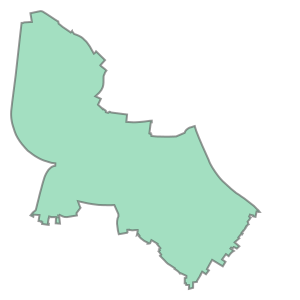

In [495]:
polygon

In [496]:
gdf.iloc[15].area_km

32.89386105662723

In [497]:
polygon.area

3289386.105662723

In [498]:
# df_map.to_csv('Tree_Segnet.csv')

In [499]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = gdf['TreeCount'].values.astype(float)
x2 = gdf['Tree'].values.astype(float)

minVal = float(np.min(x))
maxVal = float(np.max(x))

min_tree = float(np.min(x2))
max_tree = float(np.max(x2))

gdf['NormedTreeCount'] = (gdf['TreeCount']-minVal)/(maxVal-minVal)
gdf['NormedTreeSegnet'] = (gdf['Tree']-min_tree)/(max_tree-min_tree)

gdf['TreeDensity'] = np.log((gdf['TreeCount']*10.0)/gdf['area_km'])
gdf['AccessTreeDensity'] = np.log((gdf['AccessibleTreeCount']*10.0)/gdf['area_km'])
gdf['InAccessTreeDensity'] = np.log((gdf['InaccessibleTreeCount']*10.0+1)/gdf['area_km'])
# gdf['TreePixelDensity'] = np.log(gdf['TreeTotal']*10.0)/gdf['area_km']
gdf['TreePixelDensity'] = (gdf['TreeTotal']*10.0)/gdf['area_km']

In [500]:
gdf.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree',
       'TreeTotal', 'samples', 'TreeScore_norm', 'Tree_location_list',
       'TreeCount', 'Accessible_Tree_location_list', 'AccessibleTreeCount',
       'InAccessible_Tree_location_list', 'InaccessibleTreeCount',
       'NormedTreeCount', 'NormedTreeSegnet', 'TreeDensity',
       'AccessTreeDensity', 'InAccessTreeDensity', 'TreePixelDensity'],
      dtype='object')

In [501]:
gdf.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal,...,Accessible_Tree_location_list,AccessibleTreeCount,InAccessible_Tree_location_list,InaccessibleTreeCount,NormedTreeCount,NormedTreeSegnet,TreeDensity,AccessTreeDensity,InAccessTreeDensity,TreePixelDensity
40,"POLYGON ((41850.576 2242.806, 41846.875 2241.4...",E05000117,2.906118e+07,290.611780,"[POINT (41175.1285934652 5075.21577075735), PO...","[[0.204710648], [0.096319444], [0.132019676], ...",[0.15089063310798123],[32.139704852],0.150891,32.139705,...,"[POINT (39011.36488551315 3742.869002695981), ...",287,"[POINT (38007.87818359784 6908.537119082903), ...",766,0.000284,1.000000,3.549292,2.290079,3.271910,1.105933
41,"POLYGON ((34565.145 10033.766, 34620.866 10056...",E05000119,1.083104e+07,108.310365,"[POINT (37042.03510687503 11328.15663409748), ...","[[0.17117476899999998], [0.15458333300000002],...",[0.10410696644215937],[40.497609946],0.104107,40.497610,...,"[POINT (36912.54879758254 11919.18832299826), ...",3093,"[POINT (36449.97228421961 13010.89059996876), ...",3183,0.277904,0.579721,6.298765,5.654481,5.683195,3.739034
42,"POLYGON ((37385.195 8891.354, 37385.395 8892.1...",E05000108,8.314380e+06,83.143797,"[POINT (38313.03715865826 13184.94833450051), ...","[[0.0103125], [0.122881944], [0.068576389], [0...",[0.09915180070289856],[27.365896994],0.099152,27.365897,...,"[POINT (38793.95089617278 10846.29968987484), ...",1349,"[POINT (39341.74965696351 11738.33274609808), ...",1904,0.117306,0.535206,5.910795,5.089132,5.433778,3.291394
43,"POLYGON ((42614.447 5426.089, 42614.547 5427.7...",E05000110,1.257249e+07,125.724883,"[POINT (42479.16319885966 8884.716352782474), ...","[[0.15932291699999998], [0.170219907], [0.1159...",[0.112082297913738],[35.081759246999994],0.112082,35.081759,...,"[POINT (42715.51222719185 9061.156800184079), ...",2367,"[POINT (44694.44339364776 9489.524830857903), ...",1581,0.144499,0.651367,5.642065,5.237868,4.834365,2.790359
44,"POLYGON ((36984.970 2971.258, 36972.565 2992.7...",E05000107,8.286513e+06,82.865128,"[POINT (37445.16374423186 6022.580530579493), ...","[[0.181359954], [0.09803819400000001], [0.1450...",[0.11515560701825396],[14.509606484299999],0.115156,14.509606,...,"[POINT (38895.71821380212 4554.769258472661), ...",655,"[POINT (38111.63148976208 3750.667653895653), ...",812,0.020821,0.678976,5.109396,4.370006,4.584994,1.750991


In [502]:
gdf['GSV_samples_per_sqkm'] = 0
samplesPerWard = {}
for index, row in gdf.iterrows():
    samplesPerWard[row['borough_name']] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    gdf.at[index,'GSV_samples_per_sqkm'] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    

In [503]:
gdf['decile'] = pd.qcut(gdf['GSV_samples_per_sqkm'], q=10, precision=0)

In [504]:
gdf['decile_treeDensity'] = pd.qcut(gdf['TreeDensity'], q=10, precision=0)

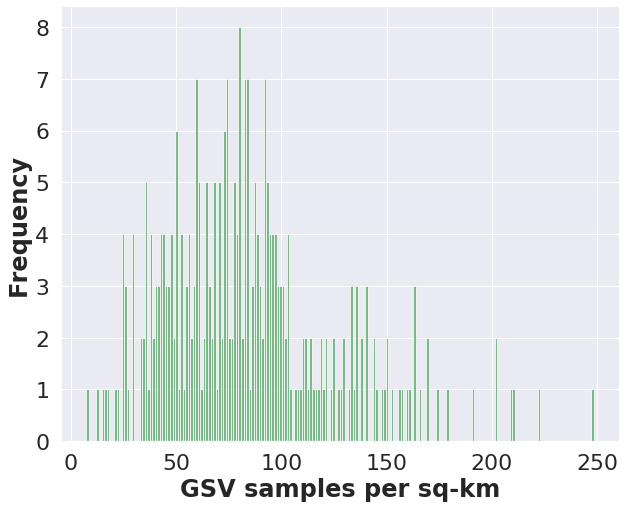

In [505]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('GSV samples per sq-km')
plt.ylabel('Frequency')
# plt.axvline(, color='r')
# plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(samplesPerWard.values(), 200, facecolor='g', alpha=0.75)

In [506]:
min(gdf['AccessibleTreeCount'])

23

In [507]:
len(gdf)

296

In [508]:
# df_map.head()

In [509]:
from scipy.stats import pearsonr

In [510]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['TreeDensity'])
print(corr)

(0.6805119700883617, 1.3415847892632254e-41)


Text(12, 4, 'Pearson r: 0.68***')

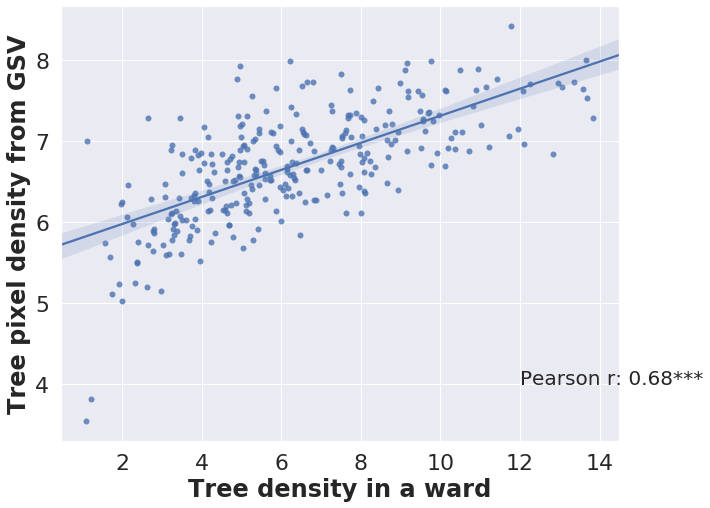

In [511]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set(font_scale=2) 
sns.regplot(x="TreePixelDensity", y="TreeDensity", data=gdf);
plt.xlabel('Tree density in a ward')
plt.ylabel('Tree pixel density from GSV')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(12, 4),fontsize = 20)

In [512]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['AccessTreeDensity'])
print(corr)

(0.6465955407885033, 1.9454167921730382e-36)


Text(12, 4, 'Pearson r: 0.64***')

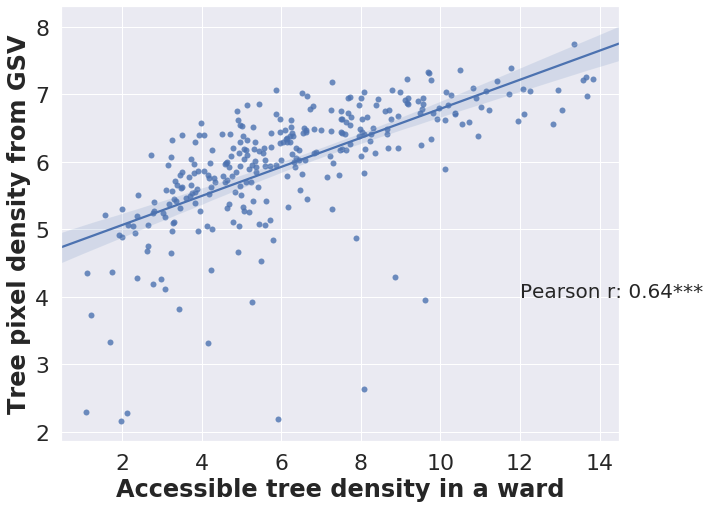

In [513]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set(font_scale=2) 
sns.regplot(x="TreePixelDensity", y="AccessTreeDensity", data=gdf);
plt.xlabel('Accessible tree density in a ward')
plt.ylabel('Tree pixel density from GSV')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(12, 4),fontsize = 20)

In [514]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['InAccessTreeDensity'])
print(corr)

(0.41297782978526393, 1.2785354758960936e-13)


Text(12, 4, 'Pearson r: 0.41***')

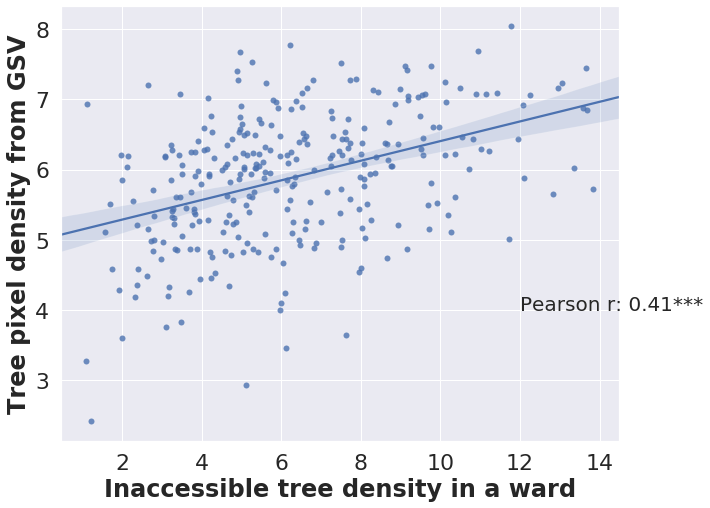

In [515]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set(font_scale=2) 
sns.regplot(x="TreePixelDensity", y="InAccessTreeDensity", data=gdf);
plt.xlabel('Inaccessible tree density in a ward')
plt.ylabel('Tree pixel density from GSV')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(12, 4),fontsize = 20)

In [516]:
greenScores = {}
for index , row in gdf.iterrows():
    if row['borough_name'] in wardCodeDict:
        greenScores[wardCodeDict[row['borough_name']]] = row['TreePixelDensity']

In [517]:
# import json
# json.dump(greenScores,open('London_ward_green_score.json','wb'))

/work/sagarj/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


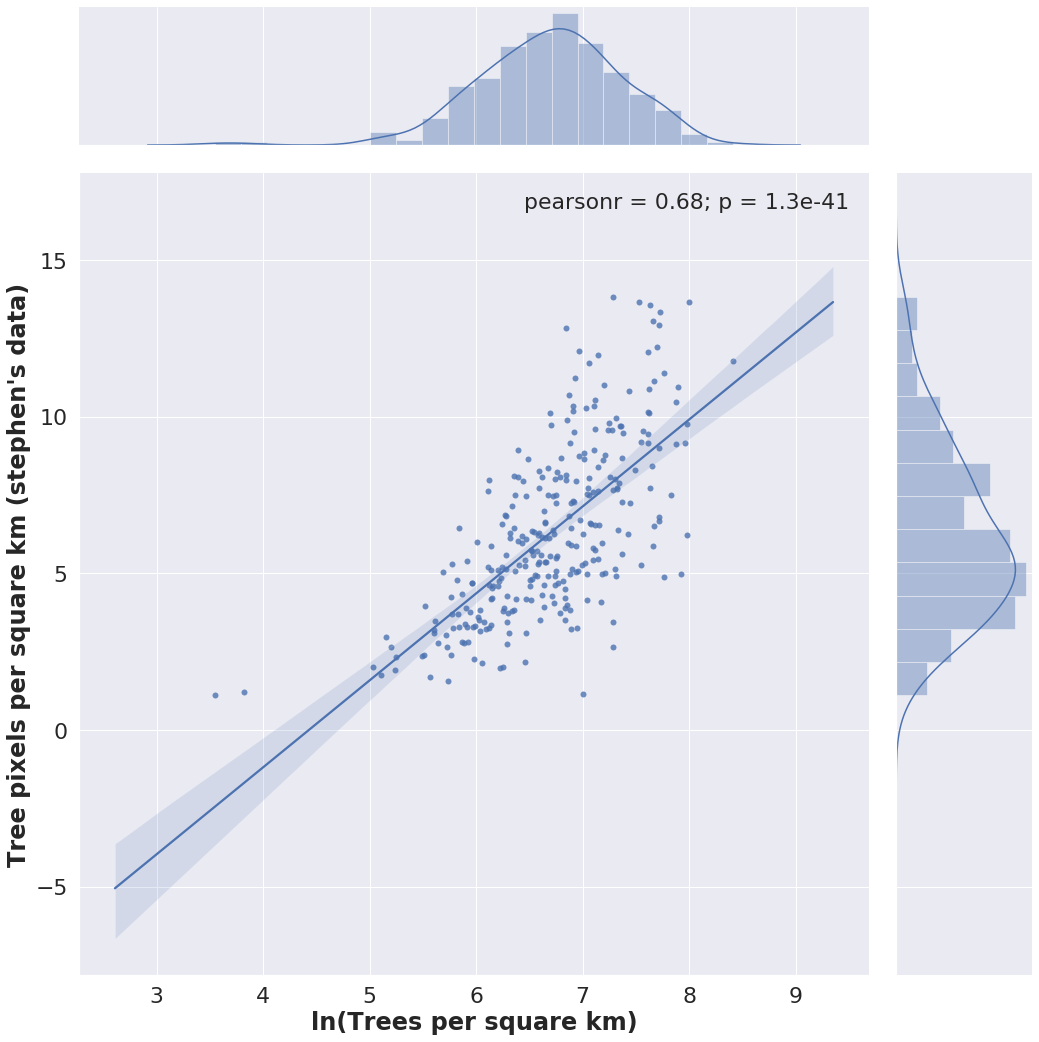

In [518]:
corr = pearsonr(gdf['TreeDensity'],gdf['TreePixelDensity'])
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=gdf,kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km (stephen\'s data)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

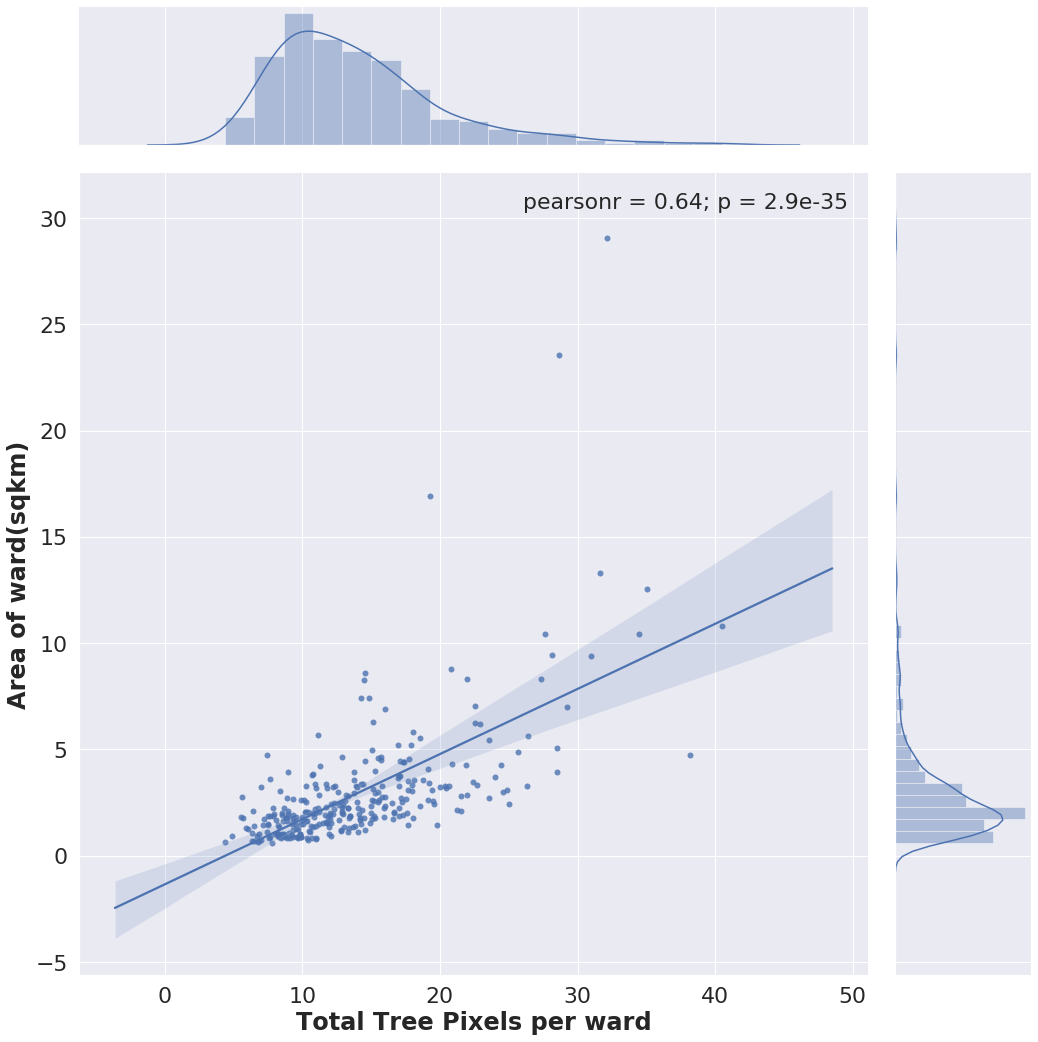

In [519]:
corr = pearsonr(gdf['TreeTotal'],gdf['area_km']/10)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x=gdf['TreeTotal'], y=gdf['area_km']/10,kind='regression',height=15);
plt.xlabel('Total Tree Pixels per ward')
plt.ylabel('Area of ward(sqkm)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

In [520]:
corrs = []
bins = []
for name, group in gdf.groupby('decile'):
    bins.append(name)
    corr = pearsonr(group['AccessTreeDensity'],group['TreePixelDensity'])
    corrs.append(corr)

In [521]:
corrs

[(0.6425100076847923, 9.73129425961421e-05),
 (0.3633292169401616, 0.05270702591642003),
 (0.5407018404213548, 0.0020362955374416433),
 (0.18291034372483245, 0.3246766666016814),
 (0.007341659110260135, 0.969849237236716),
 (0.1815420564197619, 0.32003147523465536),
 (0.3611347042962206, 0.05901178089012414),
 (0.6075521229316319, 0.0006060313090071871),
 (0.1989988052569775, 0.3100135917562068),
 (0.4953359192787955, 0.005382754103141001)]

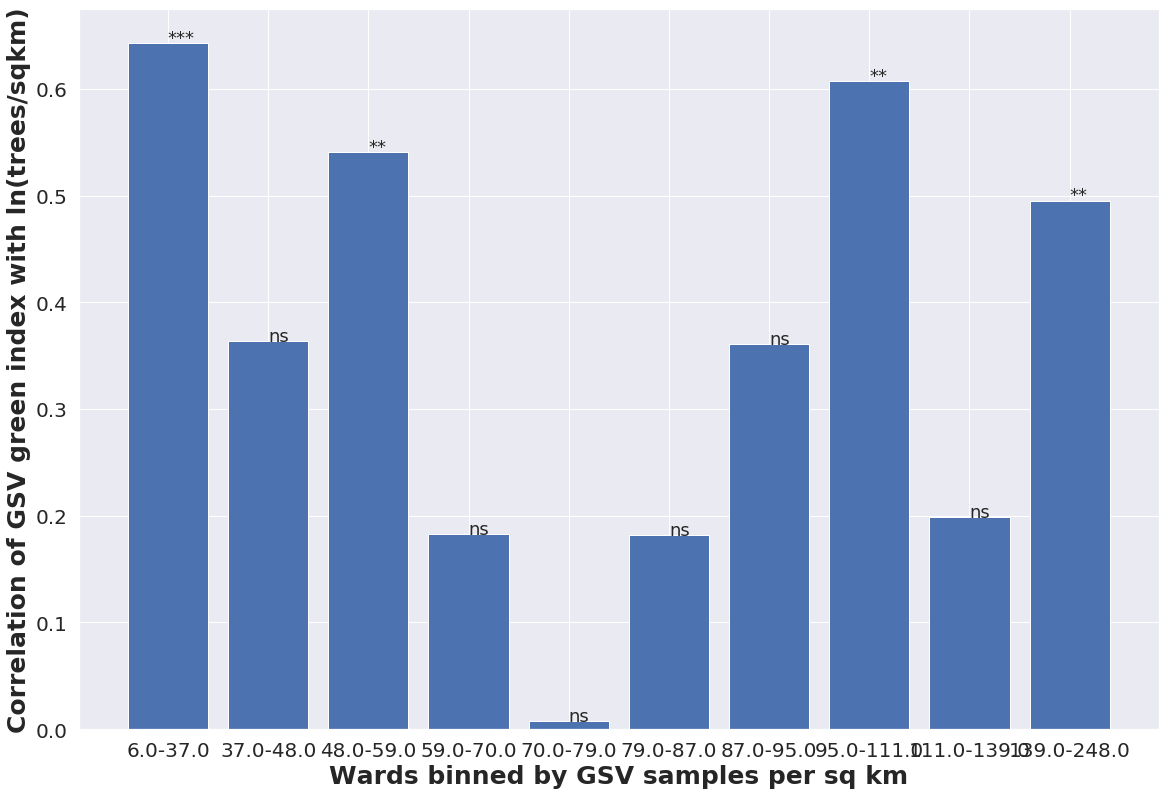

In [522]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by GSV samples per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)+'-'+str(b.right) for b in bins]
c = [corr[0] for corr in corrs]
ax.bar(xlabels,c)

p = []
for corr in corrs: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [523]:
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['borough_name'], xy=(r["AccessTreeDensity"], r["TreePixelDensity"]), 
            xytext=(2,2) , textcoords ="offset points", fontsize = 10)

In [524]:
# corrs_density = []
# bins_density = []
# for name, group in gdf.groupby('decile_treeDensity'):
#     bins_density.append(name)
#     corr = pearsonr(group['TreeDensity'],group['TreePixelDensity'])
#     sns.set(font_scale=2) 
#     ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=group,kind='regression',height=15);
#     plt.xlabel('ln(Trees per square km)')
#     plt.ylabel('Tree pixels per square km')
#     ax.annotate(pearsonr)
#     for row in group.iterrows():
#         ann(row)
#     corrs_density.append(corr)

In [525]:
corrs_density

[(0.4424150380802104, 0.0005065049426999888),
 (-0.06444009806770845, 0.6339111869231814),
 (0.04015582599337324, 0.7647255589921684),
 (0.06280305209467488, 0.6425713785908369),
 (0.05427966559504949, 0.6857117267379165),
 (0.08152494480994134, 0.5465961390312346),
 (0.08364885873155586, 0.5361605803618947),
 (0.13275343566506131, 0.32050675002822715),
 (0.21923358454206254, 0.10131567267371829),
 (0.019258619490856804, 0.8859034288944954)]

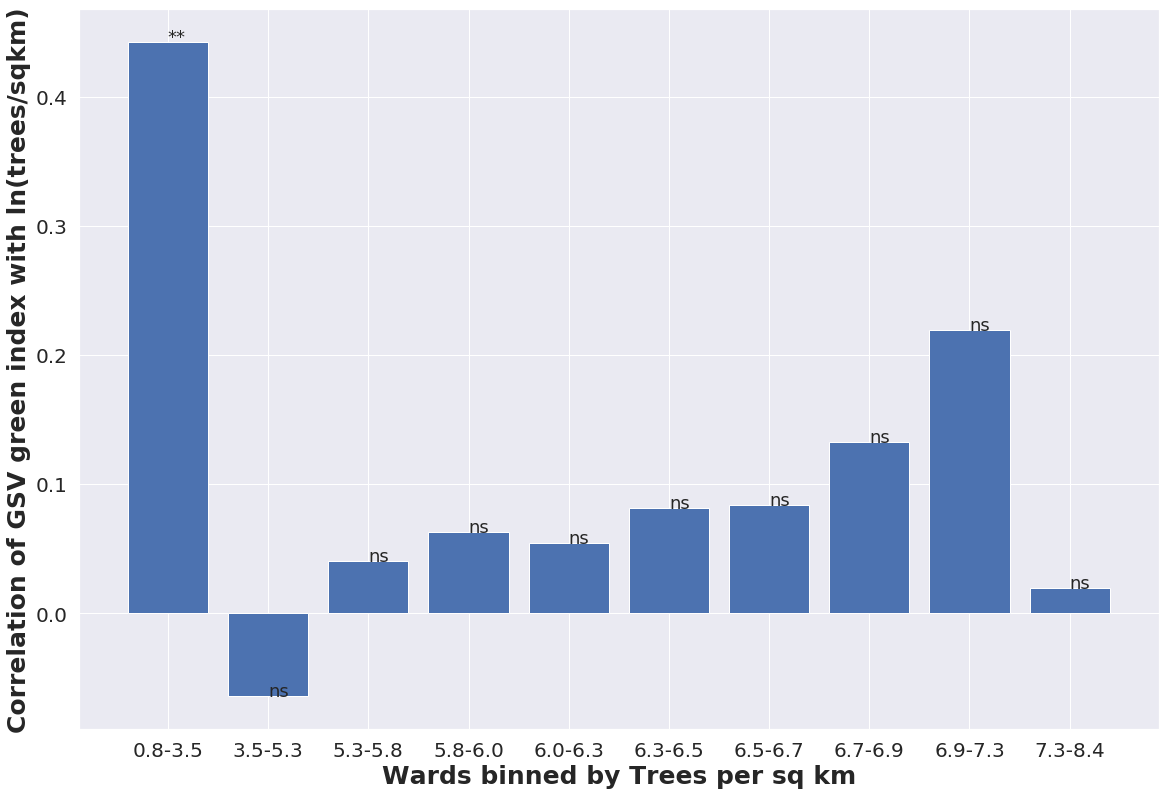

In [526]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by Trees per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)[:5]+'-'+str(b.right)[:5] for b in bins_density]
c = [corr[0] for corr in corrs_density]
ax.bar(xlabels,c)

p = []
for corr in corrs_density: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [527]:
wardpop = pd.read_csv('../Data/Geo_Data/housing-density-ward.csv')

In [528]:
wardpop = wardpop.rename(columns={'Code': 'borough_name'})

In [529]:
wardpop = wardpop[wardpop['Year']==2011]

In [530]:
ward_frame = gpd.read_file('../Data/Geo_Data/geo/london_wards.shp')

In [531]:
ward_frame.head()

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
0,Chessington South Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,52,733,50840,10884,E05000405,755.173,0.0,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Tolworth and Hook Rise Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,106,734,117160,11407,E05000414,259.464,0.0,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606..."
2,Berrylands Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,107,735,50449,11413,E05000401,145.390,0.0,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252..."
3,Alexandra Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,108,736,50456,11420,E05000400,268.506,0.0,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838..."
4,Beverley Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,109,737,117161,11417,E05000402,187.821,0.0,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921..."


In [532]:
len(ward_frame)

649

In [533]:
population = wardpop[['borough_name','Population','Population_per_square_kilometre','Ward_Name']]

In [534]:
population_stats = pd.DataFrame.merge(ward_frame,population,left_on='CODE',right_on='borough_name',how='outer')

In [535]:
len(population_stats)

649

In [536]:
population_stats.to_csv('Ward_stats.csv')

In [537]:
tree = {}
tree_density = {}
tree_pixel_density = {}
pop_density = {}
pop = {}
names = []
for index, row in gdf.iterrows():
    wardname = row['borough_name']
    names.append(wardname)
    tree_density[wardname] = row['AccessTreeDensity']
    tree[wardname] = row['AccessibleTreeCount']
    tree_pixel_density[wardname] = row['TreePixelDensity']
    
for index,row in wardpop.iterrows():
    pop_density[row['borough_name']] = np.log10(row['Population_per_square_kilometre'])
    pop[row['borough_name']] = row['Population']
    
common =  set(wardpop['borough_name']).intersection(names)
        

In [538]:
# tree

In [539]:
# pop

In [540]:
tree_to_people_ratio = {} 
for k in pop:
    if k in tree:
        tree_to_people_ratio[k] = float(tree[k])/float(pop[k])

In [541]:
vals = np.log10(list(tree_to_people_ratio.values()))
thresh_low = np.mean(vals) - np.sqrt(np.var(vals))
thresh_high = np.mean(vals) + np.sqrt(np.var(vals))

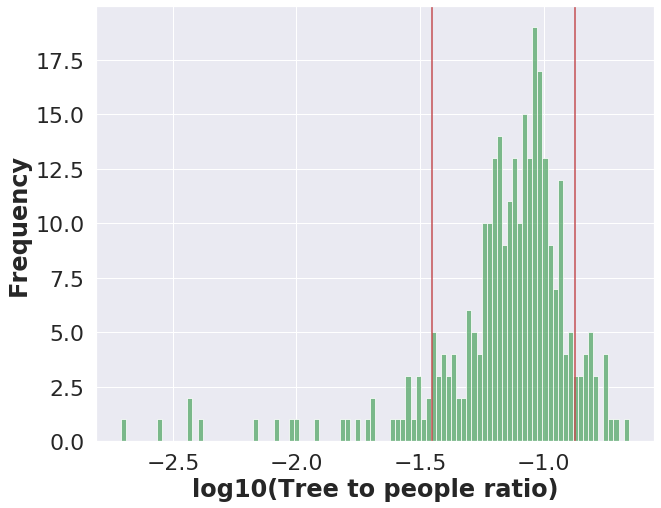

In [542]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(list(tree_to_people_ratio.values())), 100, facecolor='g', alpha=0.75)

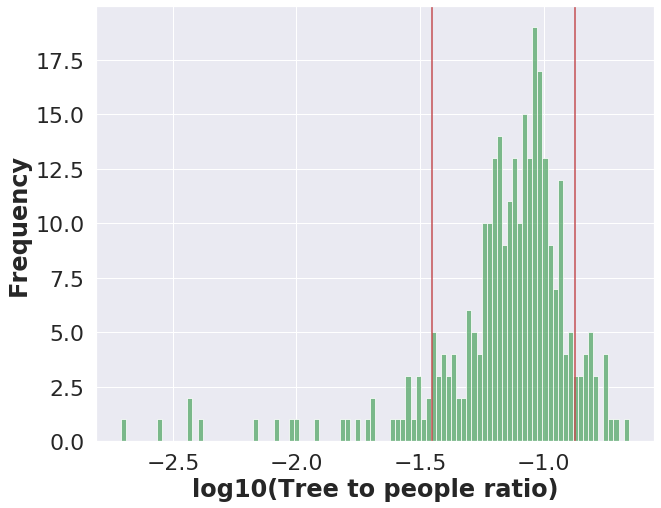

In [543]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(list(tree_to_people_ratio.values())), 100, facecolor='g', alpha=0.75)

In [544]:
filteredCommon = [k for k in common if np.log10(tree_to_people_ratio[k]) < thresh_high and  np.log10(tree_to_people_ratio[k]) > thresh_low ]

In [545]:
print ([k for k in common if np.log10(tree_to_people_ratio[k]) > thresh_high or  np.log10(tree_to_people_ratio[k]) < thresh_low ])

['E05000575', 'E05000517', 'E05000554', 'E05000127', 'E05000465', 'E05000119', 'E05000585', 'E05000497', 'E05000512', 'E05000126', 'E05000594', 'E05000118', 'E05000508', 'E05000510', 'E05000365', 'E05000511', 'E05000349', 'E05000120', 'E05000291', 'E05000122', 'E05000333', 'E05000348', 'E05000201', 'E05000496', 'E05000029', 'E05000557', 'E05000211', 'E05000500', 'E05000207', 'E05000495', 'E05000052', 'E05000199', 'E05000509', 'E05000513', 'E05000598', 'E05000499', 'E05000198', 'E05000593', 'E05000502', 'E05000179', 'E05000506', 'E05000031', 'E05000036', 'E05000524', 'E05000515', 'E05000034', 'E05000292', 'E05000191', 'E05000213', 'E05000468', 'E05000026', 'E05000110', 'E05000503', 'E05000559', 'E05000470']


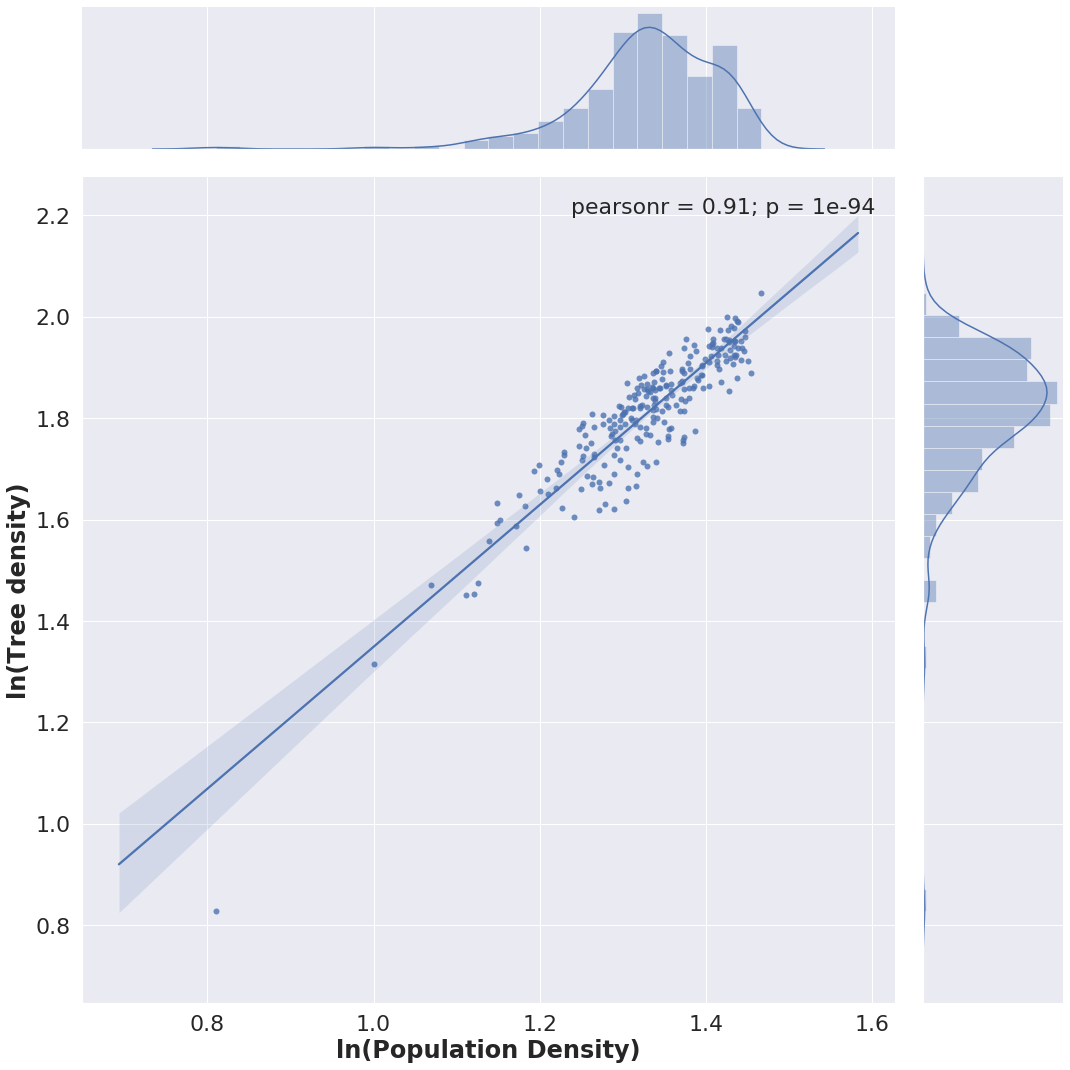

In [546]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(pop_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Population Density)')
plt.ylabel('ln(Tree density)')
ax.annotate(pearsonr)

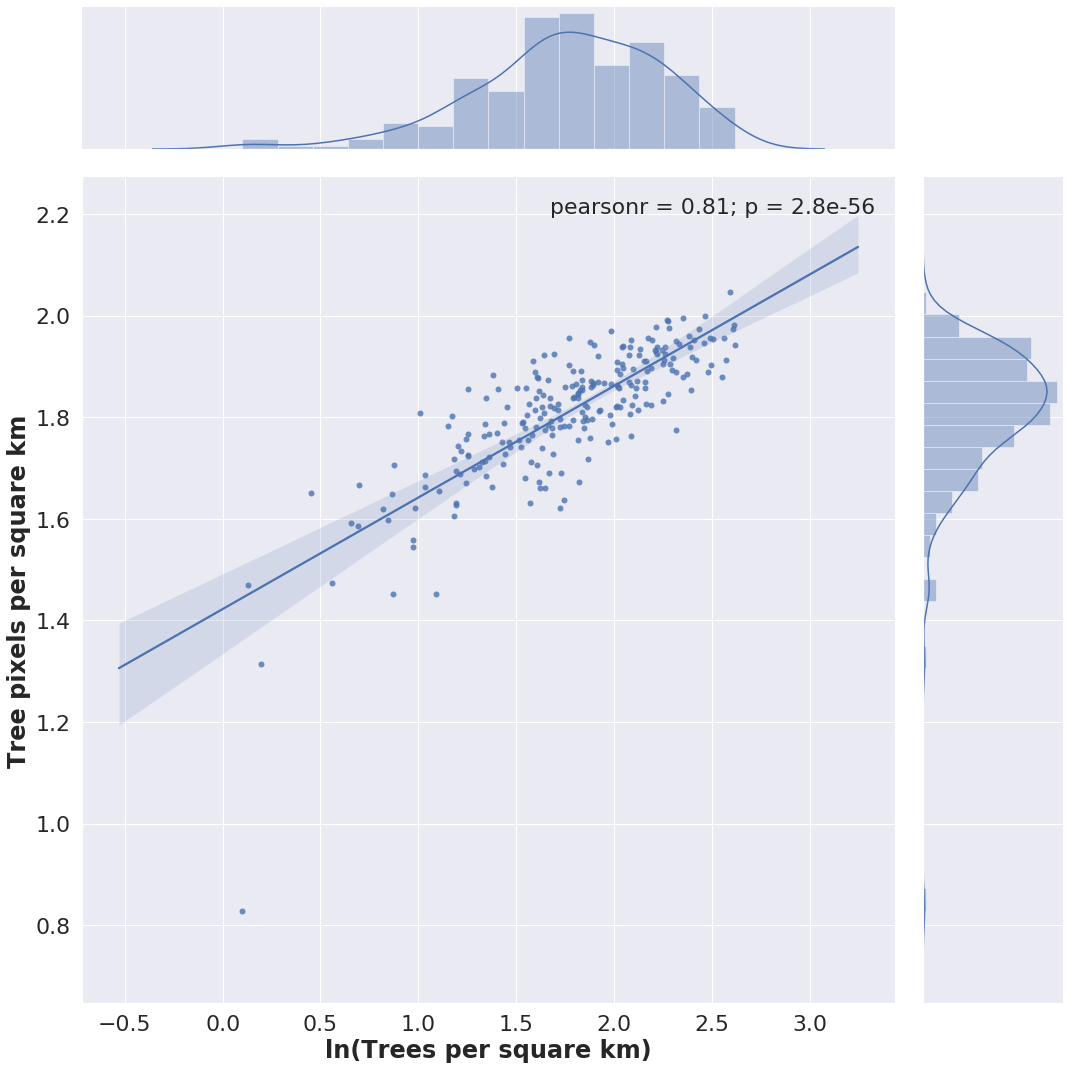

In [547]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(tree_pixel_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km')
ax.annotate(pearsonr)

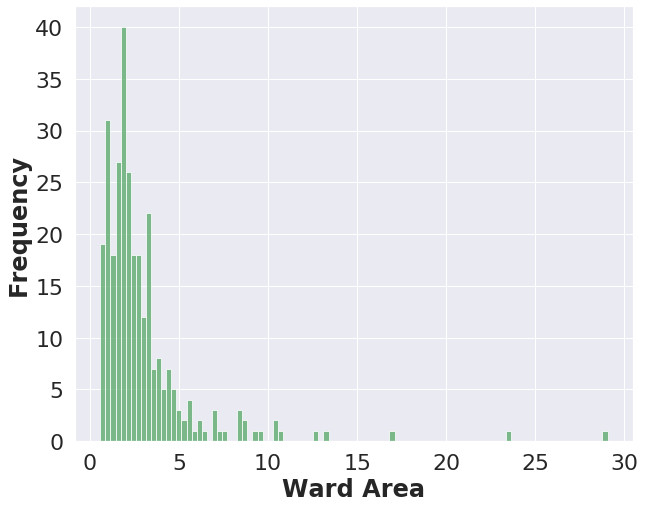

In [548]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Ward Area')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10.0, 100, facecolor='g', alpha=0.75)

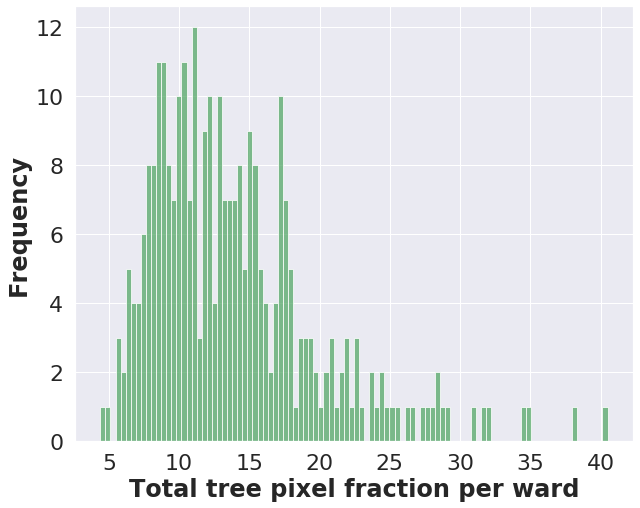

In [549]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Total tree pixel fraction per ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeTotal'], 100, facecolor='g', alpha=0.75)

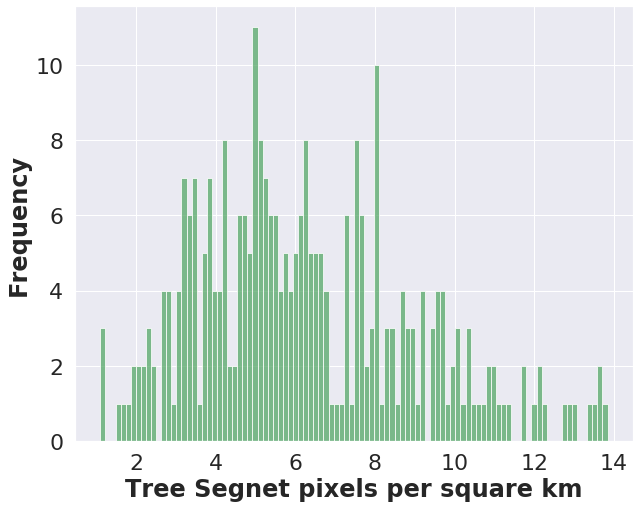

In [550]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Tree Segnet pixels per square km')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

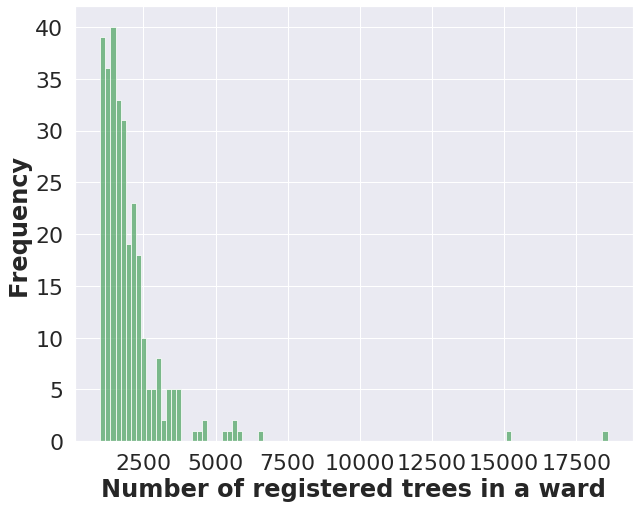

In [551]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeCount'], 100, facecolor='g', alpha=0.75)

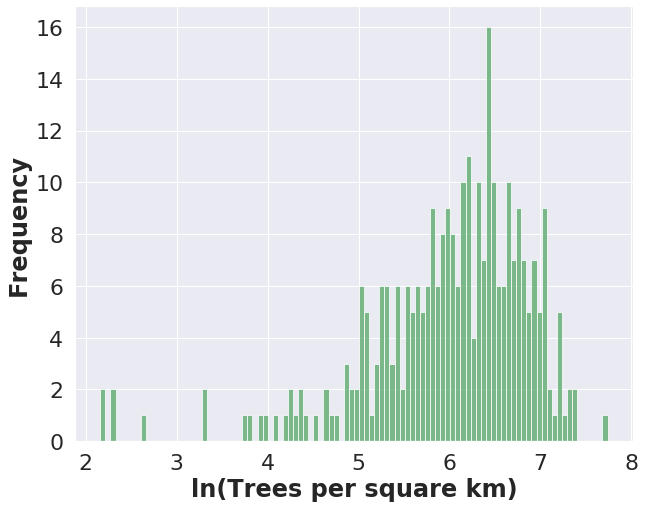

In [552]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['AccessTreeDensity'], 100, facecolor='g', alpha=0.75)

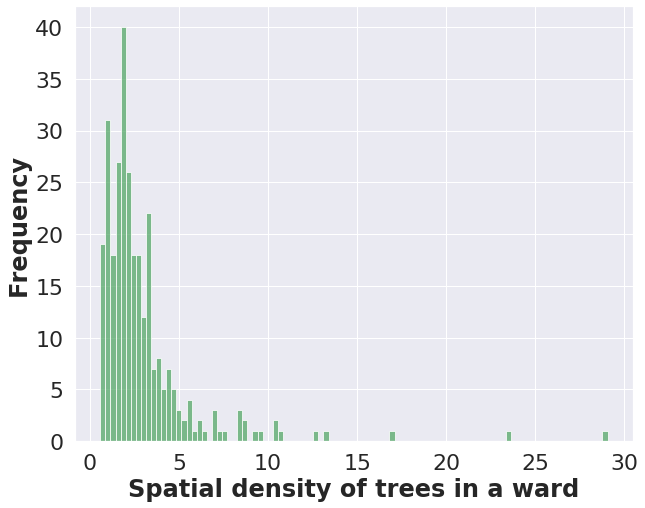

In [553]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Spatial density of trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10, 100, facecolor='g', alpha=0.75)

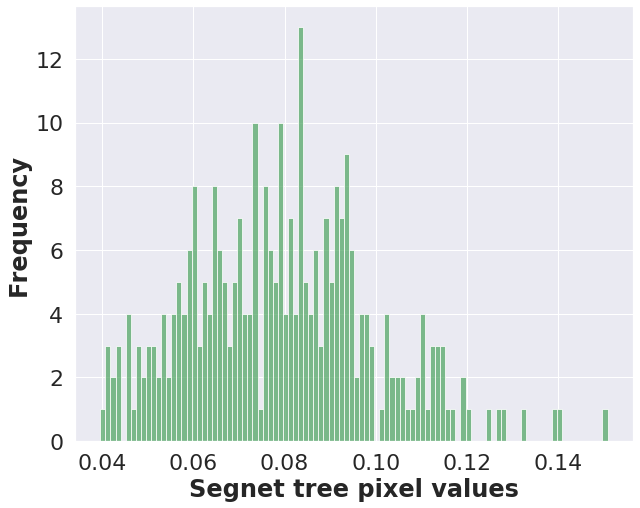

In [554]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['Tree'], 100, facecolor='g', alpha=0.75)

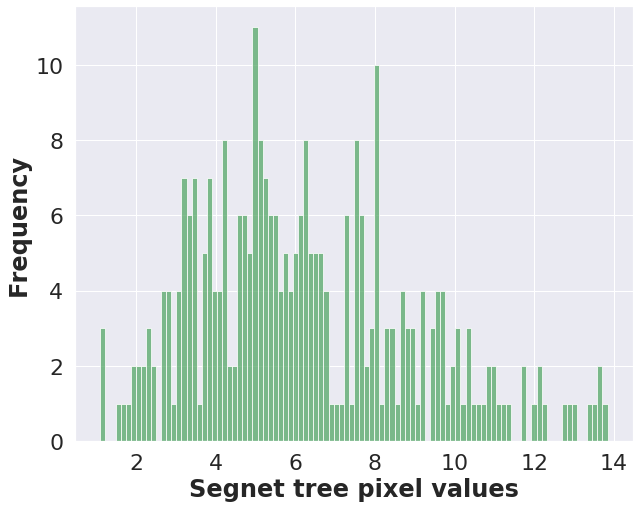

In [555]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

In [556]:
min(gdf['AccessTreeDensity'])

2.1589111426786465

In [557]:
#Work with merging wards 
Wards_LSOA_2001 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2001_Lookup_in_England_and_Wales.csv')
Wards_LSOA_2011 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2011_Lookup_in_England_and_Wales.csv')

In [558]:
merged_Wards_LSOA = pd.merge(Wards_LSOA_2001, Wards_LSOA_2011, on='LSOA01CD', how='outer')

In [559]:
# merged_Wards_LSOA.to_csv('Merged_wards_LSOA_2001_2011.csv')
merged_Wards_LSOA.head()

,LSOA01CD,LSOA01NM_x,WD01CD,WD01NM,FID_x,LSOA01NM_y,WD11CD,WD11CDO,WD11NM,FID_y
0,E01012101,Redcar and Cleveland 001B,00EEMC,Coatham,12001,Redcar and Cleveland 001B,E05001506,00EENA,Coatham,12019
1,E01012351,Darlington 004C,00EHMW,North Road,12002,Darlington 004C,E05001571,00EHNX,North Road,12008
2,E01012102,Redcar and Cleveland 001C,00EEMC,Coatham,12003,Redcar and Cleveland 001C,E05001506,00EENA,Coatham,12023
3,E01012352,Darlington 004D,00EHMW,North Road,12004,Darlington 004D,E05001571,00EHNX,North Road,12010
4,E01012353,Darlington 008B,00EHMU,Northgate South,12005,Darlington 008B,E05001572,00EHNY,Northgate,12011


In [560]:
ward_csv_CRESH = pd.read_csv('../Data/Geo_Data/uk_ward_greenspace.csv')

In [561]:
ward_csv_CRESH.head()

,casward2001,greenspace_pc
0,00AAFA,8.383184
1,00AAFE,24.354640
2,00AAFQ,10.795210
3,00AAFS,22.745890
4,00AAFT,22.767050


In [562]:
WardMap = {}
for index , row in merged_Wards_LSOA.iterrows():
    WardMap[row['WD11CDO']] = row['WD11CD']

In [563]:
len(WardMap)

8541

In [564]:
# json.dump(WardMap , open("CAS_NEW_WARD_MAPPING.json",'w'))

In [565]:
len(set(ward_csv_CRESH['casward2001']).intersection(list(merged_Wards_LSOA['WD11CDO'])))

6492

In [566]:
MedIx_score_wards = {}
for index,row in ward_csv_CRESH.iterrows():
    old = row ['casward2001']
    if old in WardMap:
        MedIx_score_wards[WardMap[old]] = row['greenspace_pc']

In [567]:
MedIx_score_wards

{'E05000001': 8.383184,
 'E05000015': 10.79521,
 'E05000021': 17.16018,
 'E05000026': 15.685620000000002,
 'E05000027': 24.04374,
 'E05000028': 18.21998,
 'E05000029': 56.84335,
 'E05000030': 58.17402,
 'E05000031': 19.18874,
 'E05000032': 13.779910000000001,
 'E05000033': 14.4604,
 'E05000034': 40.23384,
 'E05000035': 29.751509999999996,
 'E05000036': 42.36457,
 'E05000037': 24.67846,
 'E05000038': 42.90501,
 'E05000039': 53.80516,
 'E05000040': 20.13458,
 'E05000041': 50.89484,
 'E05000042': 29.498559999999998,
 'E05000043': 19.94054,
 'E05000044': 14.8701,
 'E05000045': 26.283559999999998,
 'E05000046': 17.68908,
 'E05000047': 18.65261,
 'E05000048': 40.46021,
 'E05000049': 37.2539,
 'E05000050': 57.164640000000006,
 'E05000051': 18.5158,
 'E05000052': 25.74407,
 'E05000053': 22.36515,
 'E05000054': 50.030879999999996,
 'E05000055': 24.45143,
 'E05000056': 60.06723,
 'E05000057': 57.10446999999999,
 'E05000058': 21.5744,
 'E05000059': 60.85955,
 'E05000060': 47.09506,
 'E05000061': 

In [568]:
# %store MedIx_score_wards

In [569]:
# json.dump(MedIx_score_wards,open('Ward_index_deprivation.json','wb'))

In [570]:
GLUD_green = pd.read_csv('scratchpad/satellite_borne_green_indices_percent.csv')

In [571]:
GLUD_green.head()

,WD17CD,GLUD_Area of Greenspace PCT,LCM_grass_pct,LCM_tree_pct,LCM_urban_pct,UA_Public Greenery PCT,UA_Forests PCT,StreetTrees_PCT
0,E05000026,0.199622,0.024752,0.009194,0.932815,0.064844,0.0,0.034379
1,E05000027,0.229128,0.138156,0.000000,0.858260,0.256912,0.0,0.068538
2,E05000028,0.058343,0.122918,0.000000,0.876416,0.157805,0.0,0.047912
3,E05000029,0.741304,0.185813,0.004209,0.423620,0.046093,0.0,0.174167
4,E05000030,0.459967,0.292064,0.030131,0.577416,0.459714,0.0,0.072611


In [572]:
MedixDf = pd.DataFrame.from_dict(MedIx_score_wards,orient='index')
MedixDf['GSS_CODE'] = MedixDf.index
MedixDf = MedixDf.rename(columns={0: 'green_score'})

In [573]:
MedixDf.head()


,green_score,GSS_CODE
E05000001,8.383184,E05000001
E05000015,10.795210,E05000015
E05000021,17.160180,E05000021
E05000026,15.685620,E05000026
E05000027,24.043740,E05000027


In [574]:
len(MedixDf)

6492

In [575]:
MergedGLUD = pd.merge(MedixDf, GLUD_green, left_on='GSS_CODE' , right_on='WD17CD')

In [576]:
MergedGLUD.head()

,green_score,GSS_CODE,WD17CD,GLUD_Area of Greenspace PCT,LCM_grass_pct,LCM_tree_pct,LCM_urban_pct,UA_Public Greenery PCT,UA_Forests PCT,StreetTrees_PCT
0,15.68562,E05000026,E05000026,0.199622,0.024752,0.009194,0.932815,0.064844,0.0,0.034379
1,24.04374,E05000027,E05000027,0.229128,0.138156,0.000000,0.858260,0.256912,0.0,0.068538
2,18.21998,E05000028,E05000028,0.058343,0.122918,0.000000,0.876416,0.157805,0.0,0.047912
3,56.84335,E05000029,E05000029,0.741304,0.185813,0.004209,0.423620,0.046093,0.0,0.174167
4,58.17402,E05000030,E05000030,0.459967,0.292064,0.030131,0.577416,0.459714,0.0,0.072611


(0.7748603202474922, 7.236422420064563e-98)


Text(29, 0.25, 'Pearson r: 0.77***')

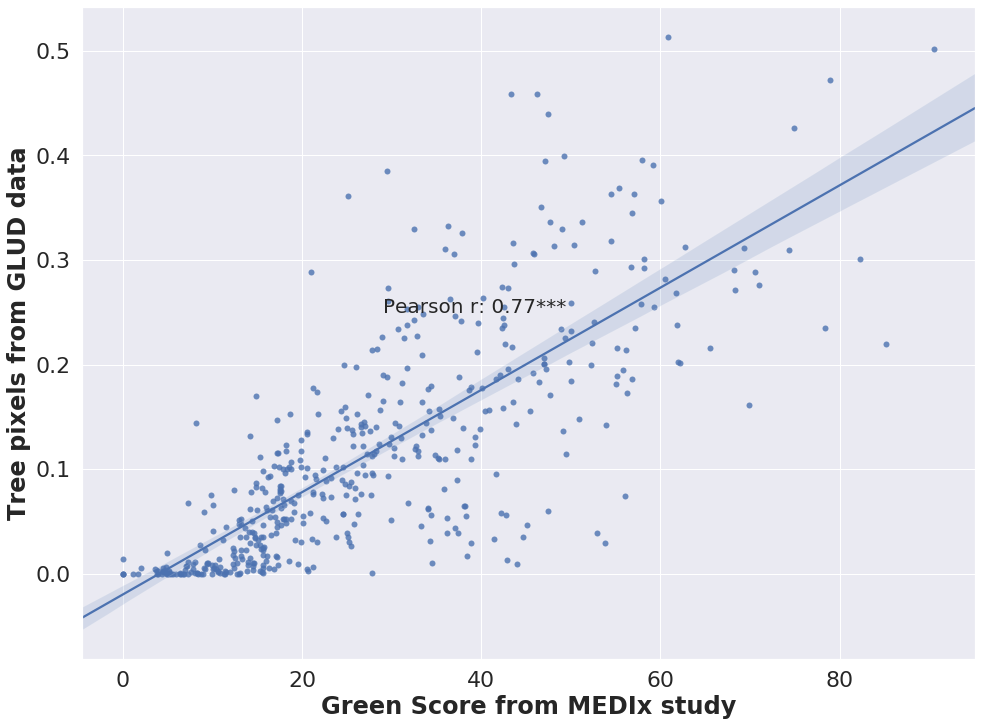

In [577]:
corr = pearsonr(MergedGLUD['green_score'],MergedGLUD['LCM_grass_pct'])
print (corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="green_score", y="LCM_grass_pct", data=MergedGLUD);
plt.xlabel('Green Score from MEDIx study')
plt.ylabel('Tree pixels from GLUD data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [578]:
# Df = pd.read_pickle('Ward_mapillary.pkl')

In [579]:
# Df.head()

In [580]:
# gdf_Df = gpd.GeoDataFrame(Df, geometry='poly', crs={'init': 'epsg:4326'})

In [581]:
gdf.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree',
       'TreeTotal', 'samples', 'TreeScore_norm', 'Tree_location_list',
       'TreeCount', 'Accessible_Tree_location_list', 'AccessibleTreeCount',
       'InAccessible_Tree_location_list', 'InaccessibleTreeCount',
       'NormedTreeCount', 'NormedTreeSegnet', 'TreeDensity',
       'AccessTreeDensity', 'InAccessTreeDensity', 'TreePixelDensity',
       'GSV_samples_per_sqkm', 'decile', 'decile_treeDensity'],
      dtype='object')

(0.6465955407885033, 1.9454167921730382e-36)


Text(29, 0.25, 'Pearson r: 0.64***')

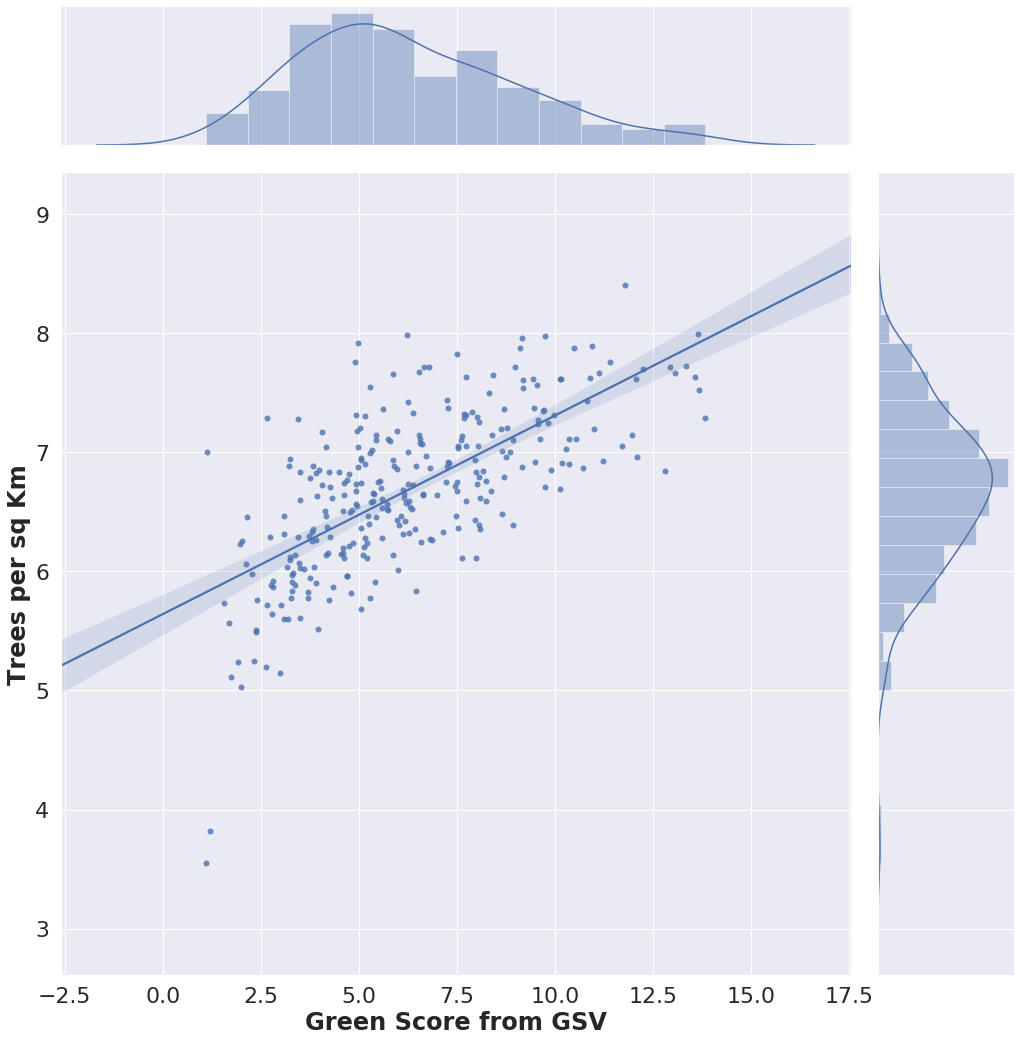

In [582]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['AccessTreeDensity'])
print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="TreePixelDensity", y="TreeDensity", data=gdf,kind='regression',height=15);
plt.xlabel('Green Score from GSV')
plt.ylabel('Trees per sq Km')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [583]:
GSV_TreeValue = gdf[['borough_name','TreePixelDensity','TreeDensity','AccessTreeDensity','InAccessTreeDensity']].copy()

In [584]:
merged_inner_GSV = pd.merge(left=MergedGLUD,right=GSV_TreeValue, left_on='GSS_CODE', right_on='borough_name')

In [585]:
merged_inner_GSV.head()

,green_score,GSS_CODE,WD17CD,GLUD_Area of Greenspace PCT,LCM_grass_pct,LCM_tree_pct,LCM_urban_pct,UA_Public Greenery PCT,UA_Forests PCT,StreetTrees_PCT,borough_name,TreePixelDensity,TreeDensity,AccessTreeDensity,InAccessTreeDensity
0,15.68562,E05000026,E05000026,0.199622,0.024752,0.009194,0.932815,0.064844,0.0,0.034379,E05000026,4.627208,6.739450,5.734051,6.351481
1,56.84335,E05000029,E05000029,0.741304,0.185813,0.004209,0.423620,0.046093,0.0,0.174167,E05000029,3.234714,6.095361,4.652261,5.858569
2,19.18874,E05000031,E05000031,0.159329,0.032101,0.002270,0.950389,0.170070,0.0,0.051067,E05000031,4.970966,6.881526,5.639045,6.584152
3,40.23384,E05000034,E05000034,0.396789,0.263430,0.002023,0.717465,0.391951,0.0,0.075583,E05000034,4.274494,6.712172,5.005905,6.538989
4,29.75151,E05000035,E05000035,0.222520,0.123873,0.011141,0.831565,0.234745,0.0,0.042656,E05000035,6.249736,7.420701,6.625018,6.863419


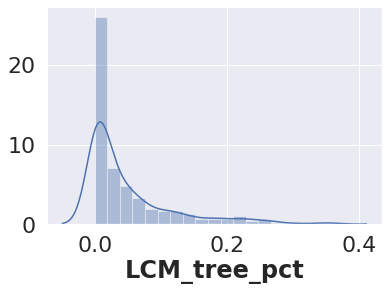

In [586]:
sns.distplot(merged_inner_GSV['LCM_tree_pct'])

(0.7748754686315213, 1.0256589570598991e-51)


Text(60, 20, 'Pearson r: 0.77***')

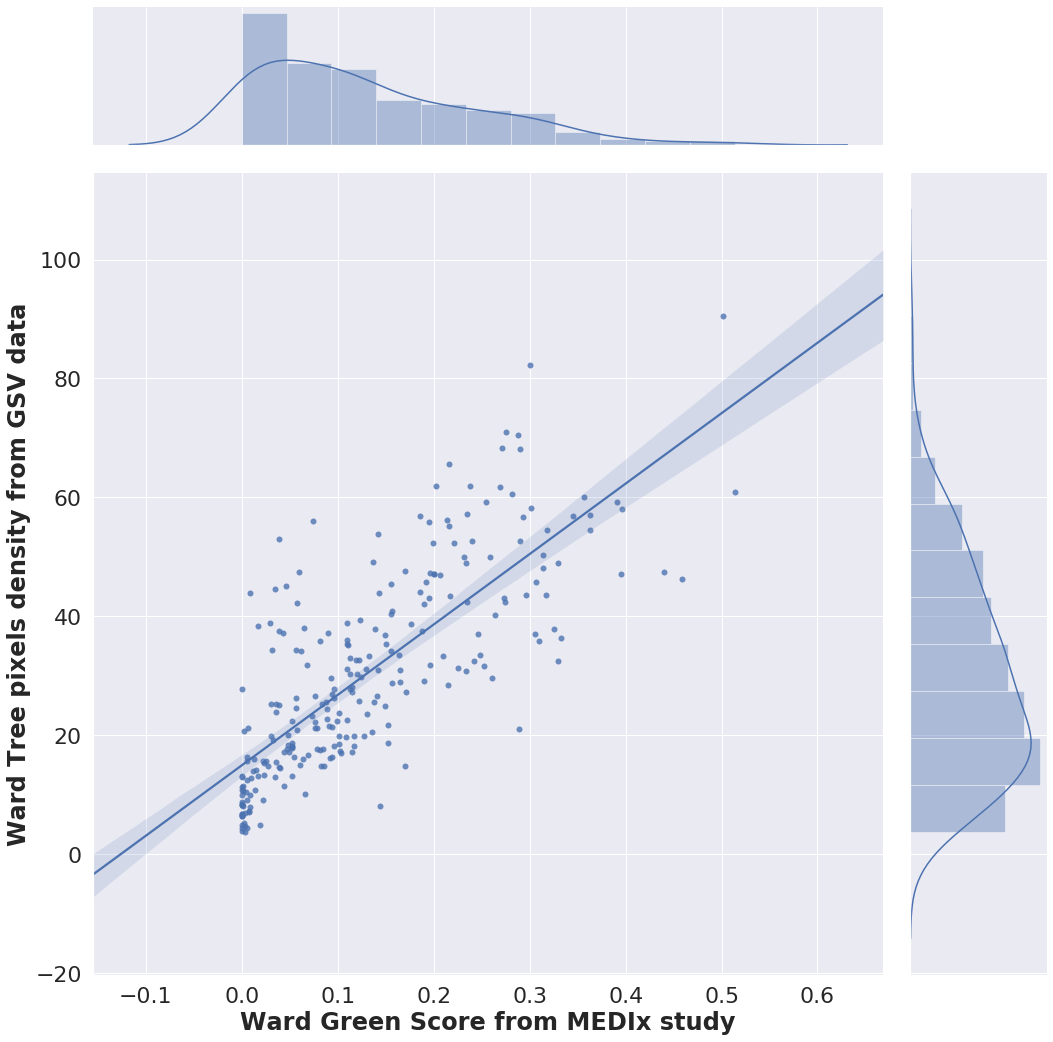

In [587]:
corr = pearsonr(merged_inner_GSV['LCM_grass_pct'],merged_inner_GSV['green_score'])
print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="LCM_grass_pct", y="green_score", data=merged_inner_GSV,kind='regression',height=15);
plt.xlabel('Ward Green Score from MEDIx study')
plt.ylabel('Ward Tree pixels density from GSV data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(0.918668110146116, 7.882231356655768e-103)


Text(60, 20, 'Pearson r: 0.91***')

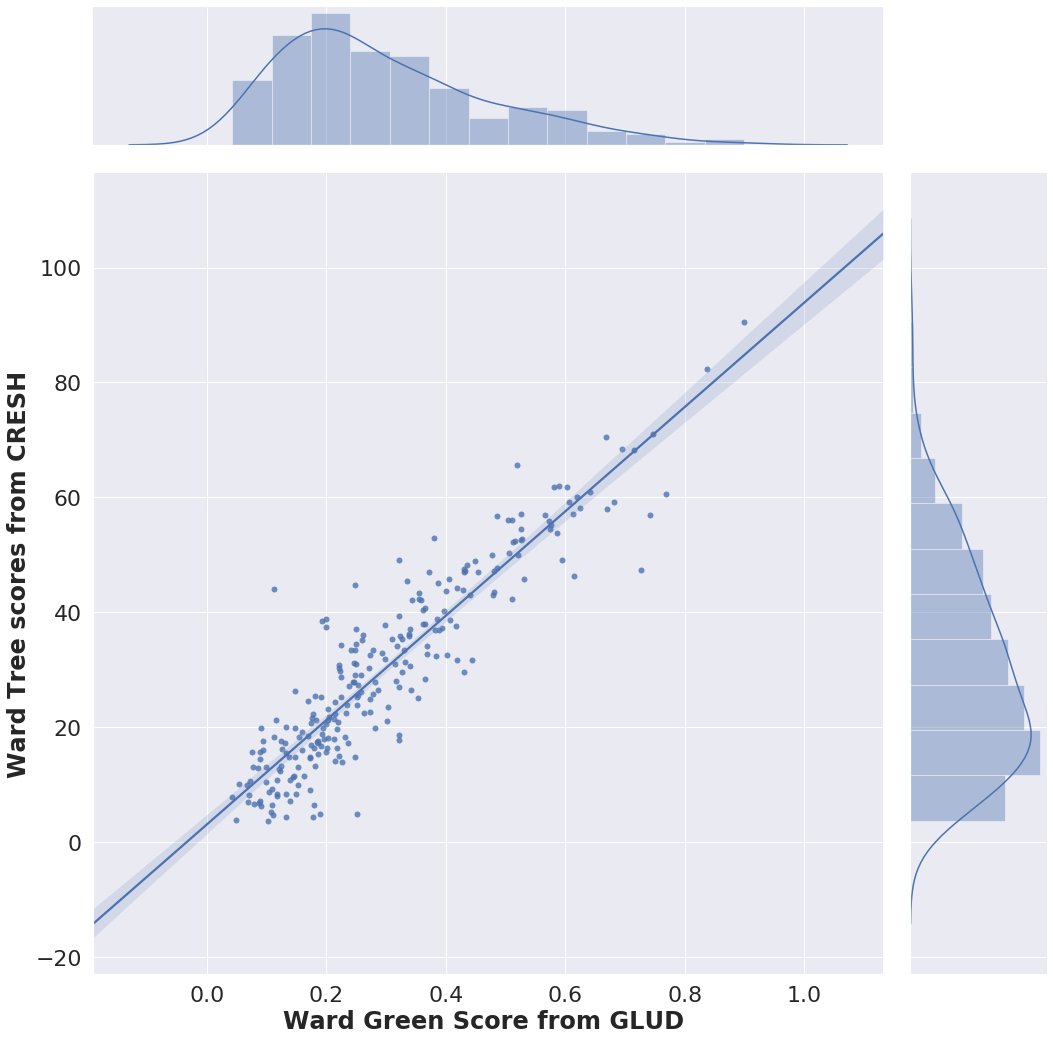

In [597]:
corr = pearsonr(merged_inner_GSV['GLUD_Area of Greenspace PCT'],merged_inner_GSV['green_score'])
print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="GLUD_Area of Greenspace PCT", y="green_score", data=merged_inner_GSV,kind='regression',height=15);
plt.xlabel('Ward Green Score from GLUD ')
plt.ylabel('Ward Tree scores from CRESH')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(-0.7290137632803646, 4.802906688912343e-43)


Text(0.3, 4, 'Pearson r: -0.7***')

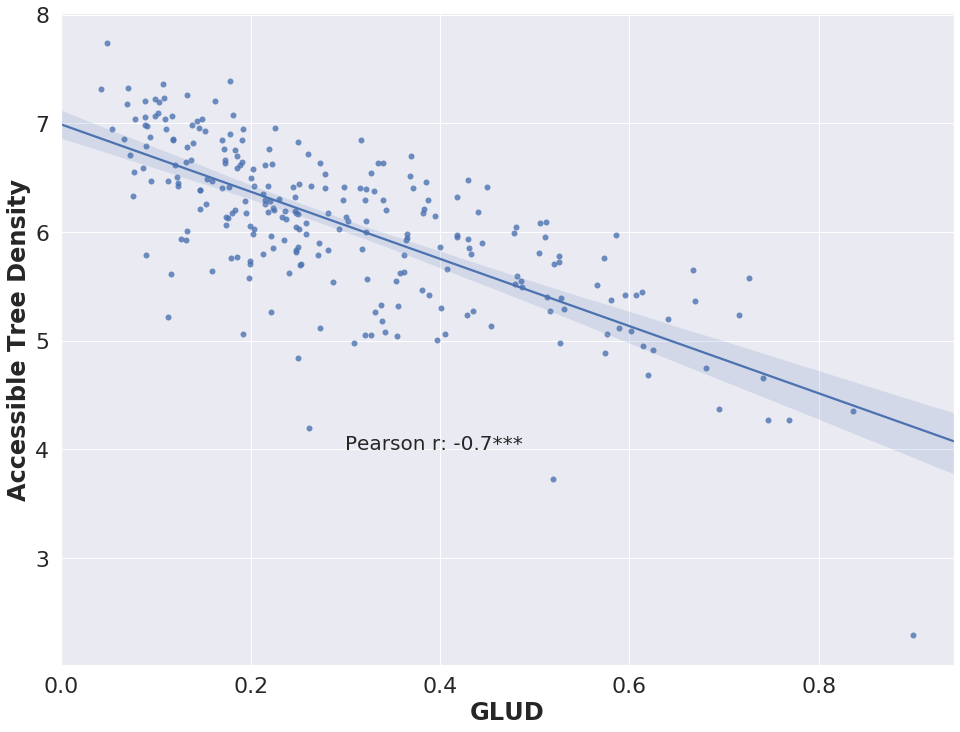

In [598]:
corr = pearsonr(merged_inner_GSV['GLUD_Area of Greenspace PCT'],merged_inner_GSV['AccessTreeDensity'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="GLUD_Area of Greenspace PCT", y="AccessTreeDensity", data=merged_inner_GSV);
plt.xlabel('GLUD')
plt.ylabel('Accessible Tree Density')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(0.3 , 4),fontsize = 20)

(-0.4095798429934041, 1.2983331322120237e-11)


Text(0.3, 3, 'Pearson r: -0.40***')

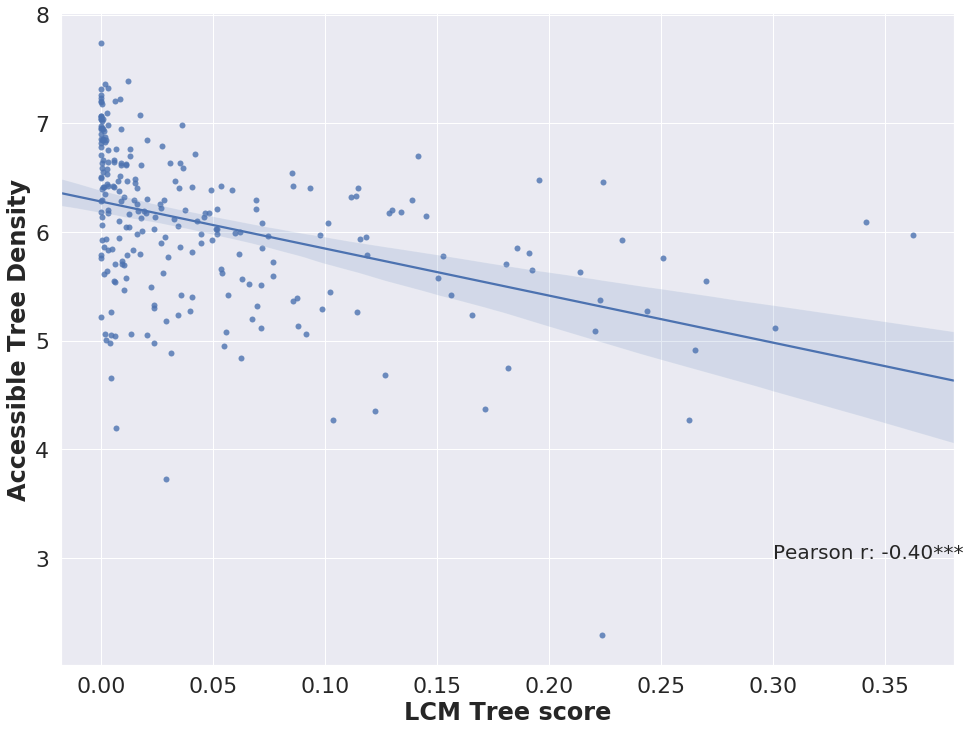

In [599]:
corr = pearsonr(merged_inner_GSV['LCM_tree_pct'],merged_inner_GSV['AccessTreeDensity'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="LCM_tree_pct", y="AccessTreeDensity", data=merged_inner_GSV);
plt.xlabel('LCM Tree score')
plt.ylabel('Accessible Tree Density')
ax.annotate("Pearson r: " +  str(corr[0])[:5] + '***',  xy=(0.3 , 3),fontsize = 20)

In [424]:
import json
diseases  = json.load(open('../Data/health_data/timeSeries_data/prevalence_disease_timeseries.json','rb'))

In [425]:
diseases['201604'].keys()

dict_keys(['Ward_Prevalence', 'Ward_Prescriptions'])

In [426]:
diseases['201604']['Ward_Prescriptions'].keys()

dict_keys(['psoriasis', "Meniere's disease", "crohn's disease", 'rheumatoid', 'irritable bowel syndrome', 'parkinson', 'sleep apnea', 'interstitial cystitis', 'bipolar', 'hypothyroidism', 'dementia', 'gastroparesis', 'depression', 'diabetes'])

In [427]:
def getDiseaase_frame(disease_dict , month ,diseaseName):
    if month in disease_dict:
        dictionary1 = disease_dict[month]['Ward_Prescriptions'][diseaseName]
        dictionary2 = disease_dict[month]['Ward_Prevalence'][diseaseName]
        data = {'GSS_CODE':[] , 'Prescriptions' : [] , 'Prevalence':[]}
        for k in dictionary2:
            data['GSS_CODE'].append(k)
            data['Prescriptions'].append(dictionary1[k])
            data['Prevalence'].append(dictionary2[k])
        dataframe = pd.DataFrame.from_dict(data)
        return dataframe

In [428]:
depression = getDiseaase_frame(diseases, '201105' , 'depression')

In [429]:
# merged_inner_GSV

In [430]:
len(depression)

7483

In [431]:
merged_disease = pd.merge(left=merged_inner_GSV,right=depression, left_on='GSS_CODE', right_on='GSS_CODE')

In [433]:
# merged_disease['tree_pixels'] = np.log(merged_disease['tree_pixels'] + 1)

In [434]:
merged_disease.head()

,green_score,GSS_CODE,WD17CD,GLUD_Area of Greenspace PCT,LCM_grass_pct,LCM_tree_pct,LCM_urban_pct,UA_Public Greenery PCT,UA_Forests PCT,StreetTrees_PCT,borough_name,TreePixelDensity,TreeDensity,AccessTreeDensity,InAccessTreeDensity,Prescriptions,Prevalence
0,15.68562,E05000026,E05000026,0.199622,0.024752,0.009194,0.932815,0.064844,0.0,0.034379,E05000026,4.627208,6.739450,5.734051,6.351481,56518.722449,3.734800
1,24.04374,E05000027,E05000027,0.229128,0.138156,0.000000,0.858260,0.256912,0.0,0.068538,E05000027,4.207532,6.082104,5.193845,5.639416,75825.884050,6.986629
2,18.21998,E05000028,E05000028,0.058343,0.122918,0.000000,0.876416,0.157805,0.0,0.047912,E05000028,4.803945,5.978550,5.572102,5.153722,100607.027835,6.954723
3,56.84335,E05000029,E05000029,0.741304,0.185813,0.004209,0.423620,0.046093,0.0,0.174167,E05000029,3.234714,6.095361,4.652261,5.858569,91649.643590,8.227078
4,58.17402,E05000030,E05000030,0.459967,0.292064,0.030131,0.577416,0.459714,0.0,0.072611,E05000030,1.683950,5.279865,4.427144,4.781984,65307.585932,5.696754


(0.002952873815868371, 0.9512026068396884)


Text(0, 0.5, 'Rheumatoid Prevalence')

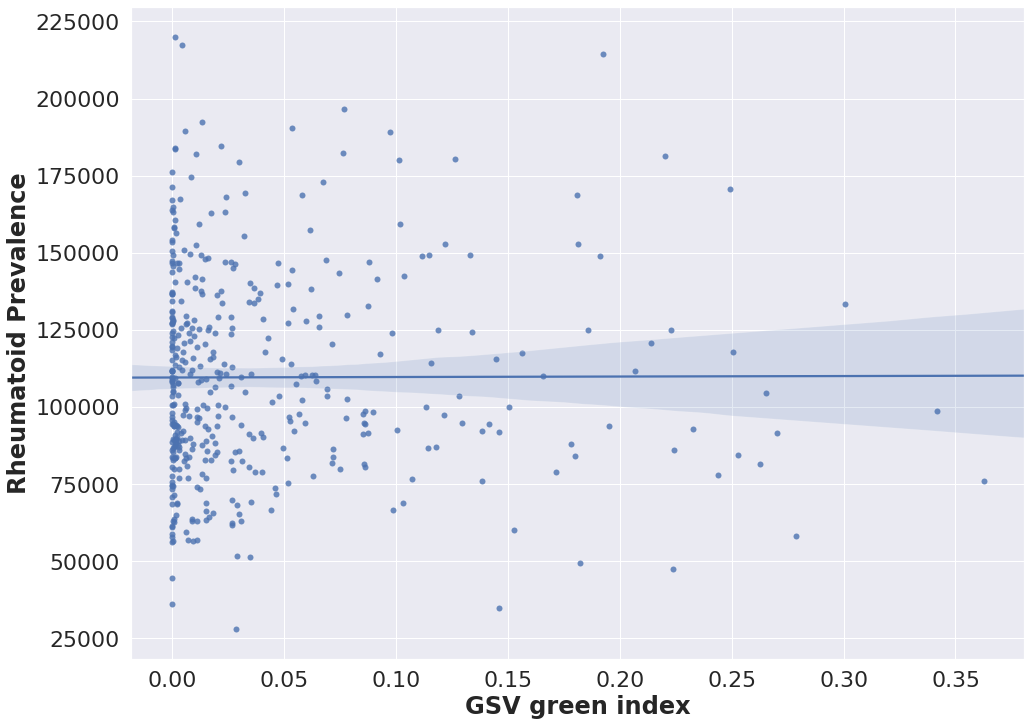

In [435]:
corr = pearsonr(merged_disease['LCM_tree_pct'],merged_disease['Prescriptions'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="LCM_tree_pct", y="Prescriptions", data=merged_disease);
plt.xlabel('GSV green index')
plt.ylabel('Rheumatoid Prevalence')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(0.15698967129373712, 0.0010609763607608604)


Text(0, 0.5, 'Depression Prevalence')

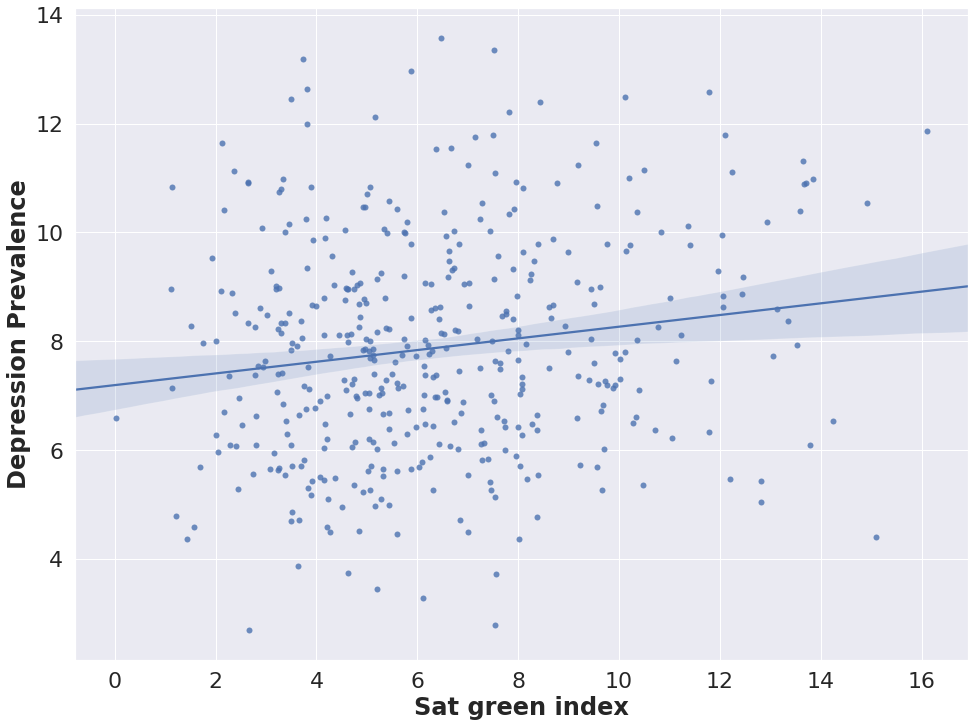

In [436]:
corr = pearsonr(merged_disease['TreePixelDensity'],merged_disease['Prevalence'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreePixelDensity", y="Prevalence", data=merged_disease);
plt.xlabel('Sat green index')
plt.ylabel('Depression Prevalence')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

In [437]:
merged_disease.corr()

,green_score,GLUD_Area of Greenspace PCT,LCM_grass_pct,LCM_tree_pct,LCM_urban_pct,UA_Public Greenery PCT,UA_Forests PCT,StreetTrees_PCT,TreePixelDensity,TreeDensity,AccessTreeDensity,InAccessTreeDensity,Prescriptions,Prevalence
green_score,1.000000,0.916004,0.779416,0.650297,-0.846592,0.377513,0.432671,0.266744,-0.703119,-0.333735,-0.390045,-0.211321,-0.063606,-0.014282
GLUD_Area of Greenspace PCT,0.916004,1.000000,0.830554,0.691837,-0.840841,0.439282,0.448382,0.152350,-0.626362,-0.293339,-0.360662,-0.177215,-0.023752,0.043923
LCM_grass_pct,0.779416,0.830554,1.000000,0.481098,-0.777235,0.503037,0.323112,0.065406,-0.614193,-0.281748,-0.314458,-0.196921,-0.064716,0.047726
LCM_tree_pct,0.650297,0.691837,0.481098,1.000000,-0.638977,0.388988,0.612674,-0.105030,-0.337290,-0.193729,-0.203361,-0.150828,0.002953,0.080444
LCM_urban_pct,-0.846592,-0.840841,-0.777235,-0.638977,1.000000,-0.402181,-0.441190,-0.230496,0.654182,0.309775,0.352208,0.201790,0.051245,-0.025487
UA_Public Greenery PCT,0.377513,0.439282,0.503037,0.388988,-0.402181,1.000000,-0.107526,-0.257904,-0.255552,-0.151864,-0.161871,-0.153724,-0.148511,-0.063495
UA_Forests PCT,0.432671,0.448382,0.323112,0.612674,-0.441190,-0.107526,1.000000,0.085564,-0.256948,-0.103989,-0.111435,-0.057772,0.029133,0.111420
StreetTrees_PCT,0.266744,0.152350,0.065406,-0.105030,-0.230496,-0.257904,0.085564,1.000000,-0.325104,-0.182671,-0.200338,-0.112405,-0.065009,-0.151749
TreePixelDensity,-0.703119,-0.626362,-0.614193,-0.337290,0.654182,-0.255552,-0.256948,-0.325104,1.000000,0.302721,0.359189,0.189384,0.109062,0.156990
TreeDensity,-0.333735,-0.293339,-0.281748,-0.193729,0.309775,-0.151864,-0.103989,-0.182671,0.302721,1.000000,0.941751,0.914080,0.053962,0.111467
